## Preparation of data

In [23]:
import load_data_multitox as ld
import dataloaders_sigma as dl
from Model_train_test_regression import Net, EarlyStopping, train, test

import pandas as pd
import numpy as np

import torch
from torch.utils import data as td
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter

import sys 
import os
import glob

from sklearn.model_selection import train_test_split

from tensorboardX import SummaryWriter

import time
from sklearn.preprocessing import MinMaxScaler#StandardScaler

import json

import matplotlib.pyplot as plt

# number of conformers created for every molecule
NUM_CONFS = 100

# amount of chemical elements taking into account
AMOUNT_OF_ELEM = 9

# amount of target values
TARGET_NUM = 29

#dataset folder
# DATASET_PATH="~/Tox21-MultiTox/MultiTox"
DATASET_PATH="./"

#logs path
LOG_PATH=os.path.join(DATASET_PATH,"logs_sigma_right")


#models path
MODEL_PATH=os.path.join(DATASET_PATH,"models_sigma_right")

In [3]:
EXPERIMENT_NUM=19

In [4]:
path="./"

In [5]:
with open(os.path.join(path,"logs_sigma_right",'exp_'+str(EXPERIMENT_NUM),str(EXPERIMENT_NUM)+'_parameters.json'),'r') as f:
  args = json.load(f)

In [6]:
args

{'EPOCHS_NUM': 100,
 'PATIENCE': 25,
 'SIGMA': 1.2,
 'BATCH_SIZE': 128,
 'TRANSF': 'g',
 'NUM_EXP': '19',
 'VOXEL_DIM': 50,
 'LEARN_RATE': 1e-05,
 'SIGMA_TRAIN': False}

In [34]:
LOG_PATH = os.path.join(LOG_PATH,'exp_'+str(EXPERIMENT_NUM))

MODEL_PATH = os.path.join(MODEL_PATH,'exp_'+str(EXPERIMENT_NUM))


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

print('Start loading dataset...')

# get dataset without duplicates from csv
data = pd.read_csv(os.path.join(DATASET_PATH,'database', 'MultiTox.csv'))
props = list(data)[1:]
scaler = MinMaxScaler()
data[props]=scaler.fit_transform(data[props])

# create elements dictionary
#     elements = ld.create_element_dict(data, amount=AMOUNT_OF_ELEM+1)
elements={'N':0,'C':1,'Cl':2,'I':3,'Br':4,'F':5,'O':6,'P':7,'S':8}

# read databases to dictionary
#     conf_calc = ld.reading_sql_database(database_dir='./dat/')
with open(os.path.join(DATASET_PATH,'many_elems.json'), 'r') as fp:
    conf_calc = json.load(fp)

keys=list(conf_calc.keys())
print ('Initial dataset size = ', len(keys))

new_conf_calc={}
for smiles in conf_calc.keys():
    for conf_num in conf_calc[smiles]:
        if smiles in new_conf_calc.keys():
            new_conf_calc[smiles][int(conf_num)]=conf_calc[smiles][conf_num]
        else:
            new_conf_calc[smiles]={}
            new_conf_calc[smiles][int(conf_num)]=conf_calc[smiles][conf_num]

conf_calc=new_conf_calc

elems = []
for key in keys:
    conformers=list(conf_calc[key].keys())
    for conformer in conformers:
        try:
            energy = conf_calc[key][conformer]['energy']
            elems = list(set(elems+list(conf_calc[key][conformer]['coordinates'].keys())))
        except:
            del conf_calc[key][conformer]
    if set(conf_calc[key].keys())!=set(range(100)):
          del conf_calc[key]
    elif conf_calc[key]=={}:
        del conf_calc[key]

print ('Post-processed dataset size = ', len(list(conf_calc.keys())))
# create indexing and label_dict for iteration
indexing, label_dict = ld.indexing_label_dict(data, conf_calc)
# print('Dataset has been loaded, ', int(time.time()-start_time),' s')

# start_time=time.time()
# create train and validation sets' indexes
print('Neural network initialization...')


Using device: cuda:0

GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Start loading dataset...
Initial dataset size =  13091
Post-processed dataset size =  13084
Neural network initialization...


In [15]:
train_indexes, test_indexes, _, _ = train_test_split(np.arange(0, len(conf_calc.keys())),
                                                     np.arange(0, len(conf_calc.keys())), test_size=0.2,
                                                     random_state=115)

train_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, train_indexes, dim = args['VOXEL_DIM'],print_name=True)
train_generator = td.DataLoader(train_set, batch_size=1, shuffle=True)

test_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, test_indexes, dim = args['VOXEL_DIM'],print_name=True)
test_generator = td.DataLoader(test_set, batch_size=1, shuffle=True)

## Visualization function

In [80]:
def plot_visualization_input_as_parameter(model,elements,grad_step=10**3,name=''):
    import matplotlib.pyplot as plt
    inv_elems = {v: k for k, v in elements.items()}
    print(name)

    fig,ax = plt.subplots(1,3,figsize=(15,5))
    
    data=model.x_input
    
    ax[0].imshow(data.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[0].set_title('Molecule projection')
    ax[1].imshow((data-grad_step*data.grad).cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[1].set_title('Molecule Gradient descent')
    with torch.no_grad():
        gauss_blur = model.blur(data)

    ax[2].imshow(gauss_blur.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[2].set_title('Blurred molecule')
    plt.show()
    
    molecules = data.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(molecules):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
        ax[i//3,i%3].set_title(inv_elems[i])
    fig.suptitle('Atom types in molecule')
    plt.show()
    
    molecules_blur = gauss_blur.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(molecules_blur):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
        ax[i//3,i%3].set_title(inv_elems[i])
    fig.suptitle('Blurred atom types in molecule')
    plt.show()
    
    grads = data.grad.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(grads):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
        ax[i//3,i%3].set_title(inv_elems[i])
    fig.suptitle('Grads for atom types in molecule')    
    plt.show()
    
    

## Backpropagation of existing input to its target value

In [60]:
from torch.autograd import Variable
for batch_idx, (molecule, target) in enumerate(train_generator):
    molecule = Variable(molecule.to(device),requires_grad=True)
    model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args['TRANSF'],device=device,sigma_0 = args['SIGMA'],sigma_trainable = args['SIGMA_TRAIN'], x_trainable=True, x_input=torch.randn(1,9,50,50,50))
    model=model.to(device)
    model.load_state_dict(torch.load(os.path.join(MODEL_PATH,'checkpoint.pt')))
    model.x_input=Parameter(molecule,requires_grad=True)
    target = target.to(device)
    # set gradients to zero
    output = model(model.x_input)
    # create mask to get rid of Nan's in target
    mask = (target == target)
    output_masked = torch.masked_select(output, mask).type_as(output)
    target_masked = torch.masked_select(target, mask).type_as(output)
    criterion=nn.MSELoss()
    loss = criterion(output_masked, target_masked)
    
    break

CC(=O)OC(C)c1ccccc1
C/C(NNC(N)=S)=C(\N=O)Nc1ccc(C)cc1
CC(=O)ON=C1C=CC(=O)C(=O)C=C1
CC(C)NCC(O)COc1nccc(NCc2ccccc2)c1C#N
CC(=O)OC/C(I)=C(\I)COC(C)=O
CC(C)OC(=O)C=Cc1ccc([N+](=O)[O-])o1
CC(=O)O[C@H]1C[C@@H]2CC[C@@H]3[C@H](CC[C@@]4(C)[C@H]3C[C@H](OC(C)=O)[C@@H]4[N+]3(C)CCCCC3)[C@@]2(C)C[C@@H]1[N+]1(C)CCCCC1
BrC(CNCc1ccccc1)c1ccccc1
CC1(C(CCO)C(=O)NCCc2ccccc2)OCCO1
C#CC(OC(=O)C1C(C=C(C)C)C1(C)C)/C(C)=C/CC


In [61]:
for name, param in model.named_parameters():
    print(name, type(param.data), param.size())

x_input <class 'torch.Tensor'> torch.Size([1, 9, 50, 50, 50])
conv1.weight <class 'torch.Tensor'> torch.Size([32, 9, 3, 3, 3])
conv1.bias <class 'torch.Tensor'> torch.Size([32])
conv2.weight <class 'torch.Tensor'> torch.Size([64, 32, 3, 3, 3])
conv2.bias <class 'torch.Tensor'> torch.Size([64])
conv3.weight <class 'torch.Tensor'> torch.Size([128, 64, 3, 3, 3])
conv3.bias <class 'torch.Tensor'> torch.Size([128])
conv4.weight <class 'torch.Tensor'> torch.Size([256, 128, 3, 3, 3])
conv4.bias <class 'torch.Tensor'> torch.Size([256])
fc1.weight <class 'torch.Tensor'> torch.Size([128, 256])
fc1.bias <class 'torch.Tensor'> torch.Size([128])
fc2.weight <class 'torch.Tensor'> torch.Size([29, 128])
fc2.bias <class 'torch.Tensor'> torch.Size([29])


In [63]:
loss.backward()

C#CC(OC(=O)C1C(C=C(C)C)C1(C)C)/C(C)=C/CC


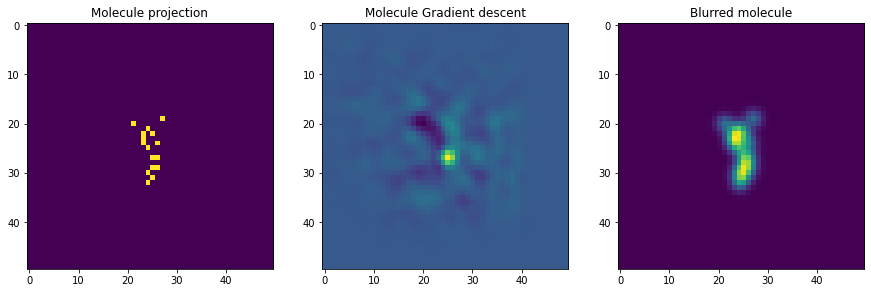

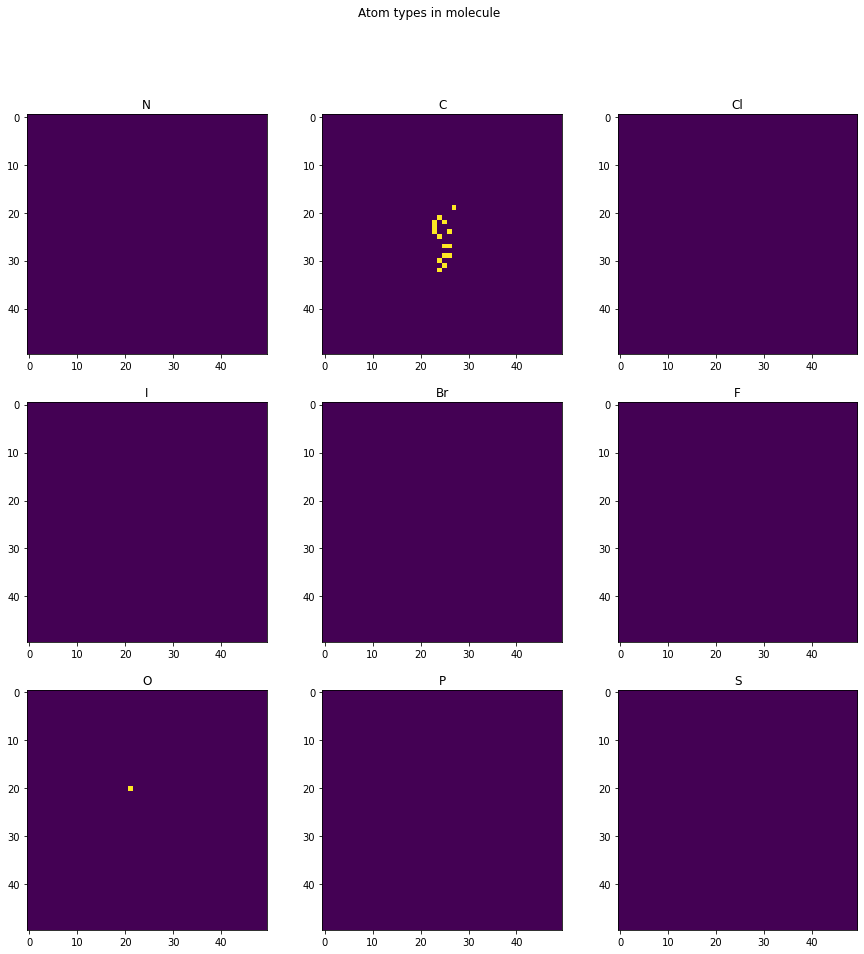

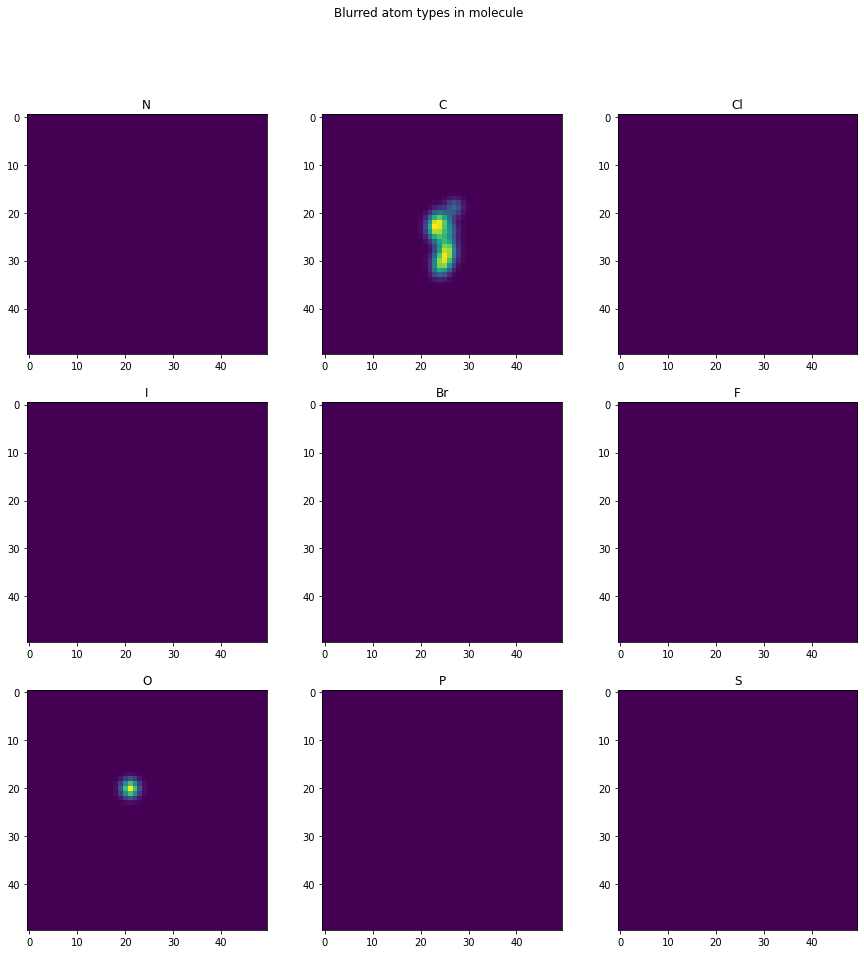

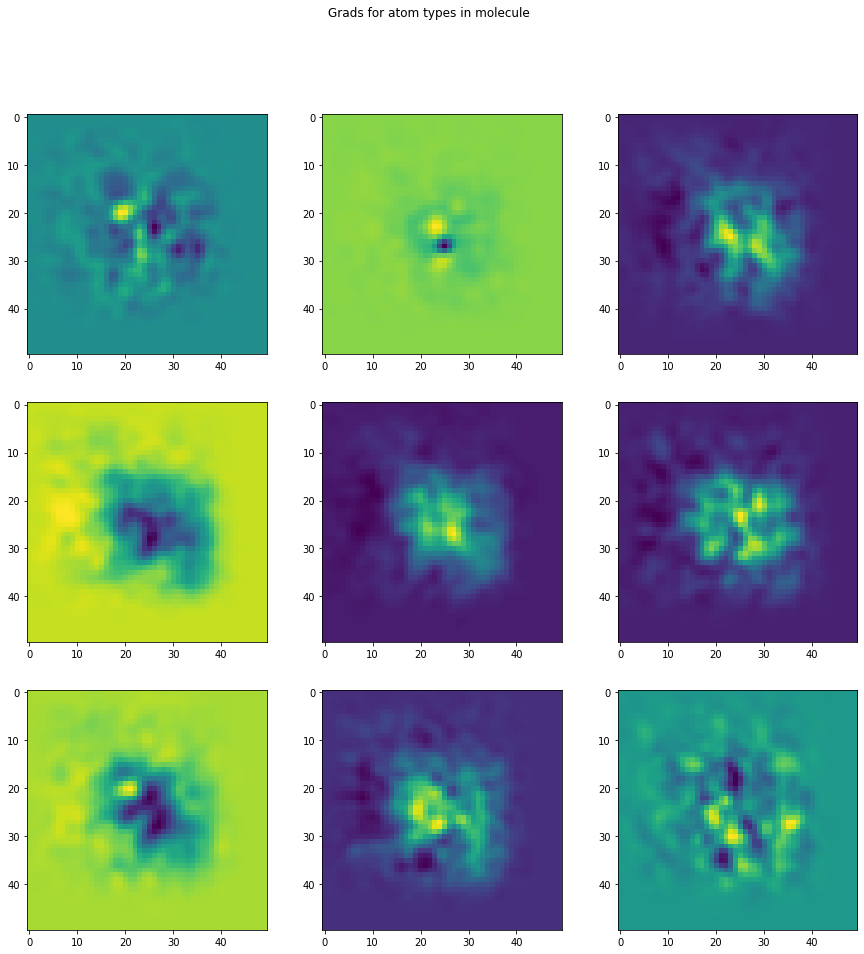

In [66]:
plot_visualization_input_as_parameter(model,elements,grad_step=10**3,name='C#CC(OC(=O)C1C(C=C(C)C)C1(C)C)/C(C)=C/CC')

In [82]:
from torch.autograd import Variable

molecule = Variable(torch.randn(1,9,50,50,50).to(device),requires_grad=True)
model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args['TRANSF'],device=device,sigma_0 = args['SIGMA'],sigma_trainable = args['SIGMA_TRAIN'], x_trainable=True, x_input=torch.randn(1,9,50,50,50))
model=model.to(device)
model.load_state_dict(torch.load(os.path.join(MODEL_PATH,'checkpoint.pt')))
model.x_input=Parameter(molecule,requires_grad=True)
target=torch.zeros(29)
# target[13]=1
target[15]=1

target = target.to(device)
output = model(model.x_input)
# create mask to get rid of Nan's in target
mask = (target == target)
output_masked = torch.masked_select(output, mask).type_as(output)
target_masked = torch.masked_select(target, mask).type_as(output)
criterion=nn.MSELoss()
loss = criterion(output_masked, target_masked)
loss.backward()

## Backpropagation of random input to one in one target and zeros in others

random input 15


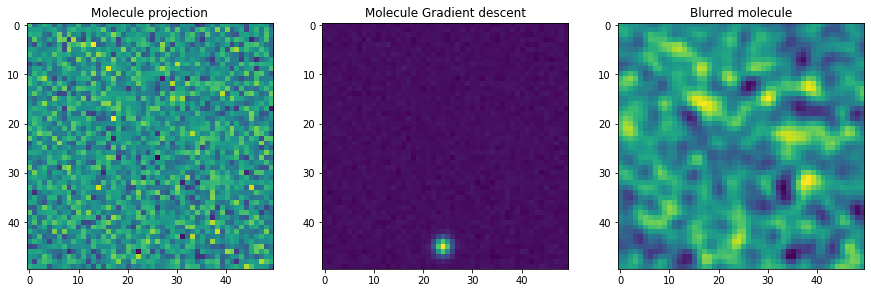

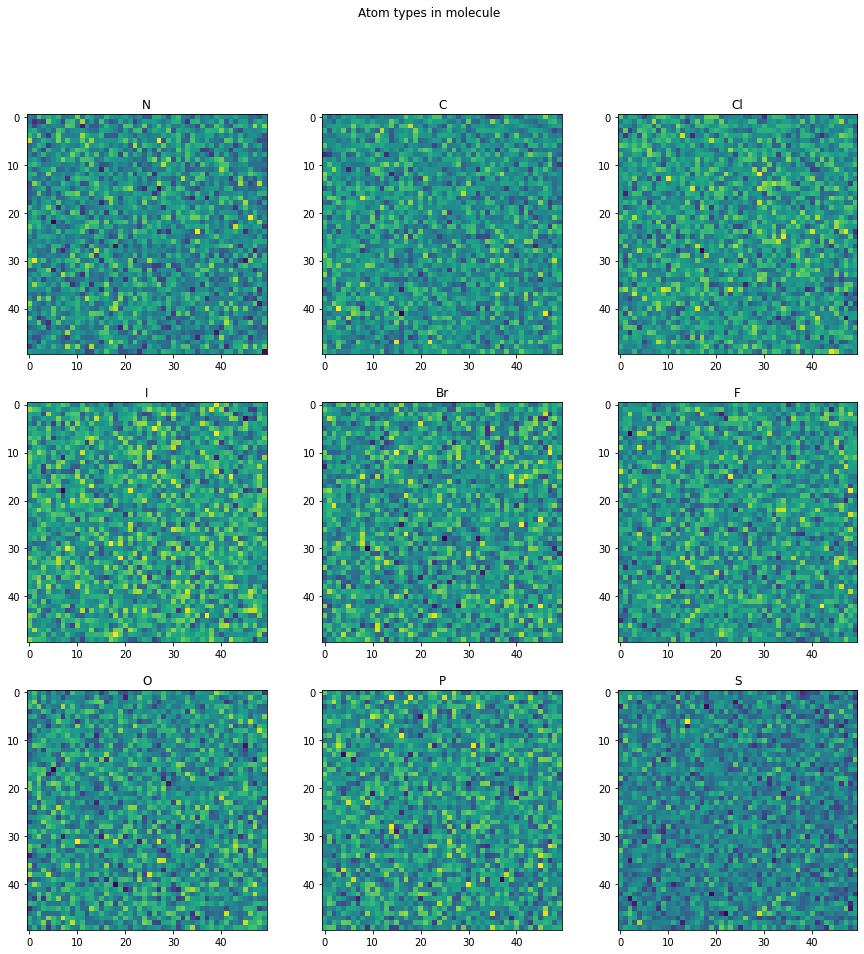

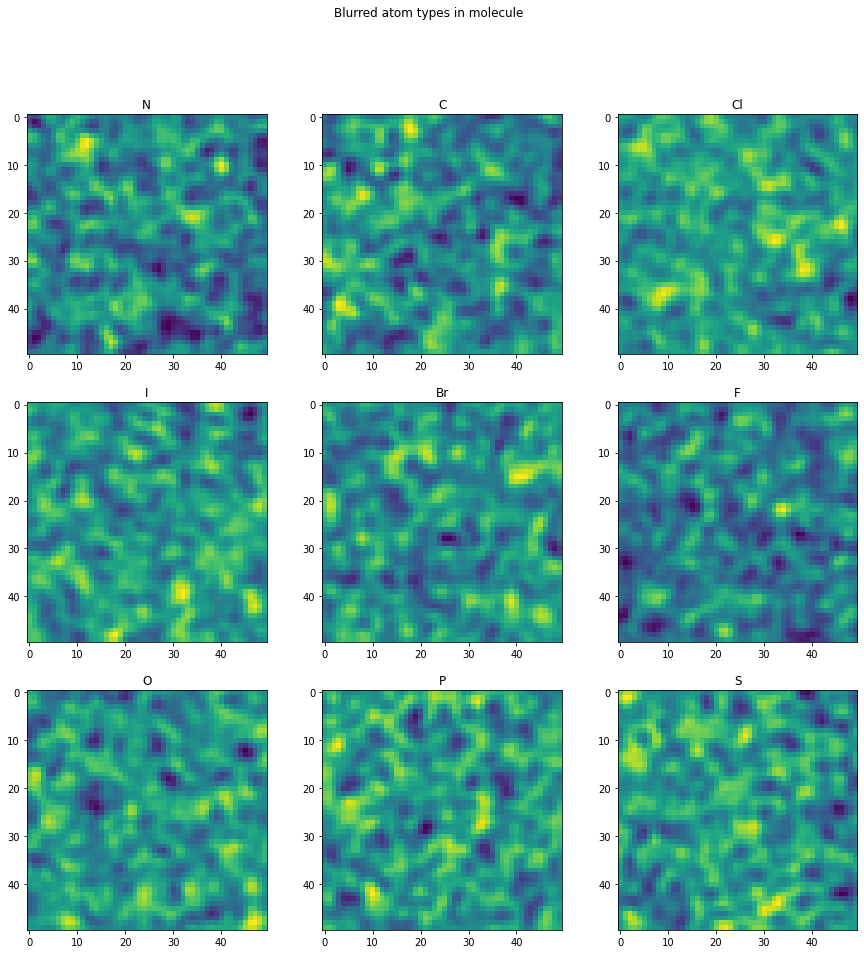

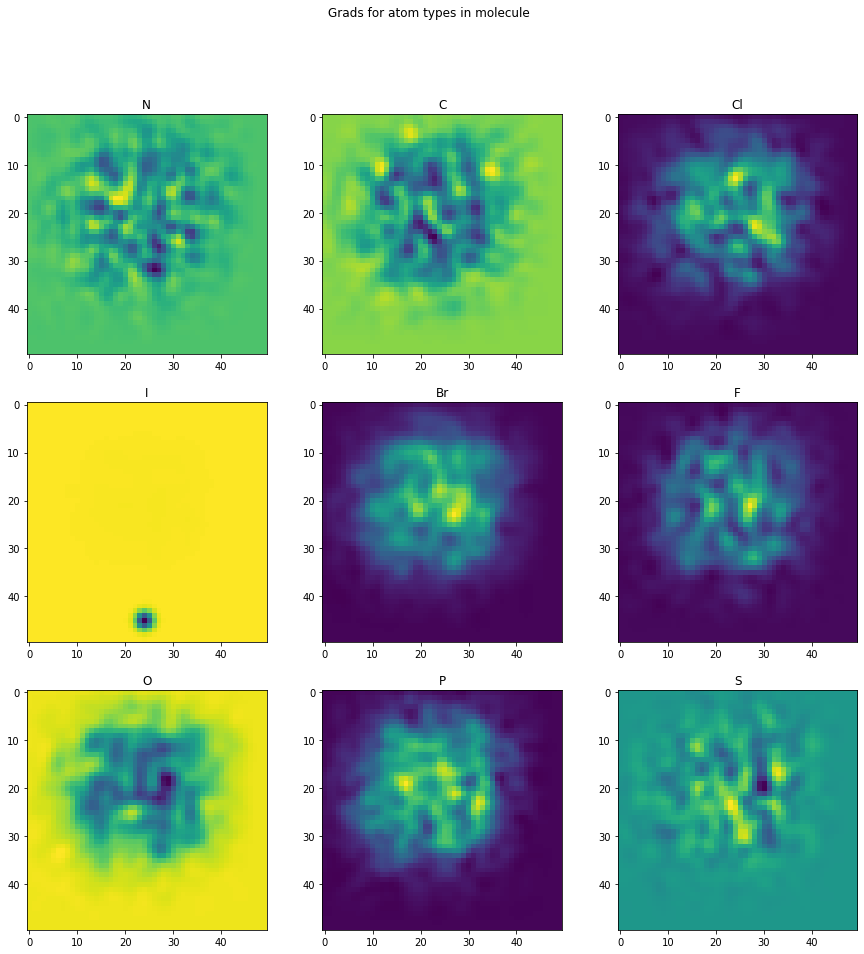

In [84]:
plot_visualization_input_as_parameter(model,elements,grad_step=10**3,name='random input 15')

## Gradiend descent for random input

0


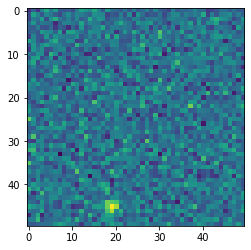

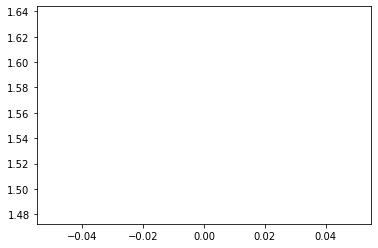

5


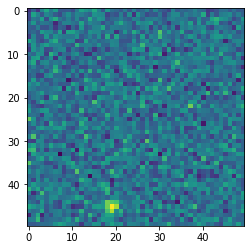

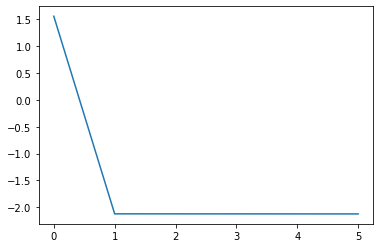

10


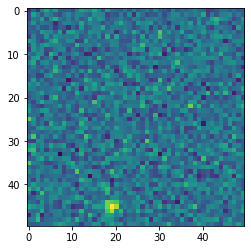

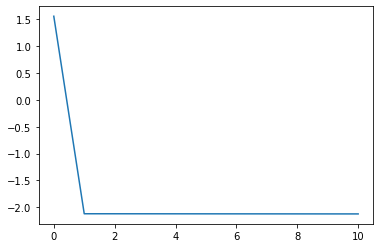

15


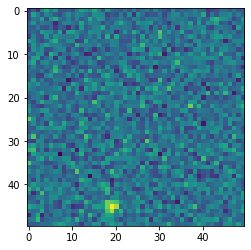

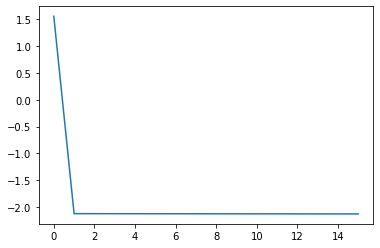

20


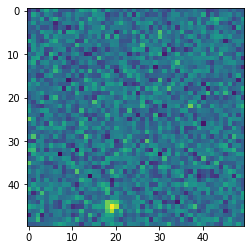

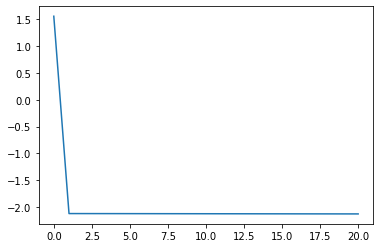

25


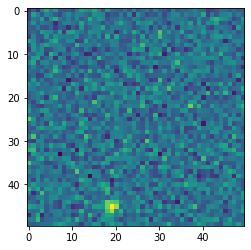

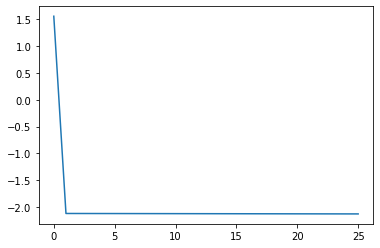

30


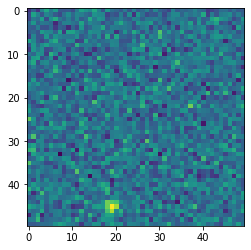

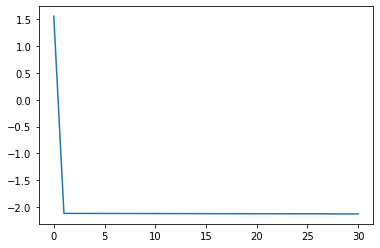

35


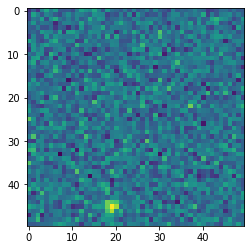

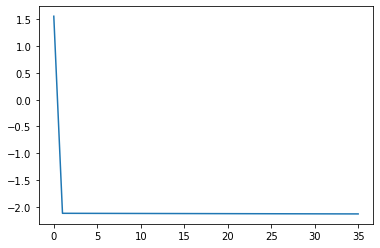

40


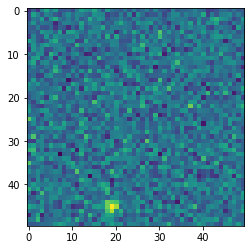

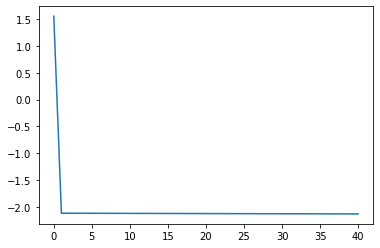

45


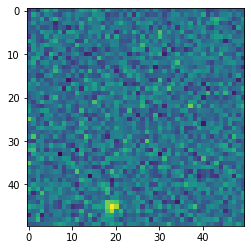

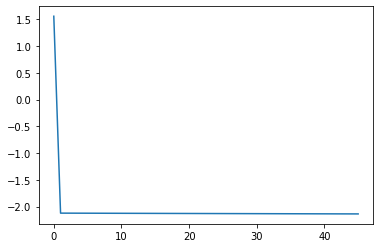

50


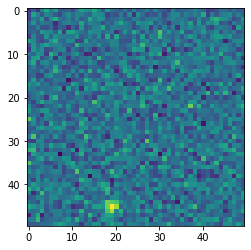

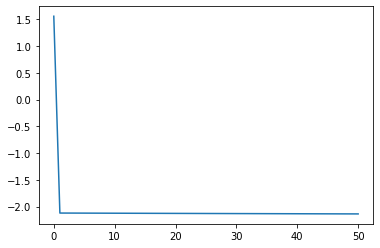

55


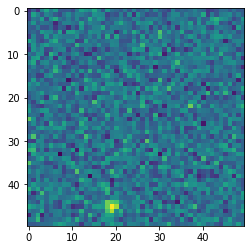

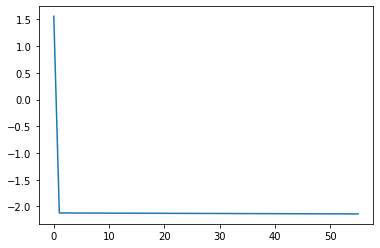

60


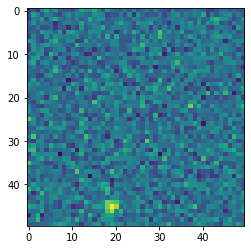

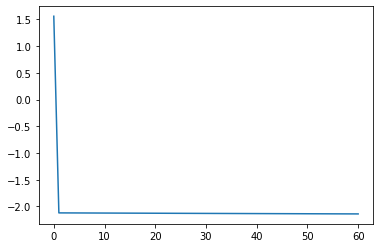

65


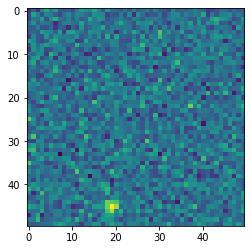

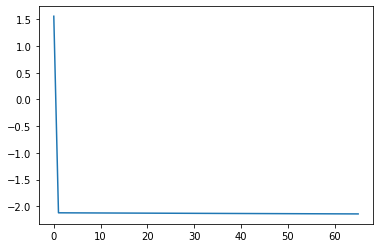

70


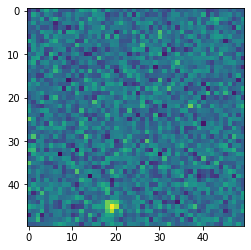

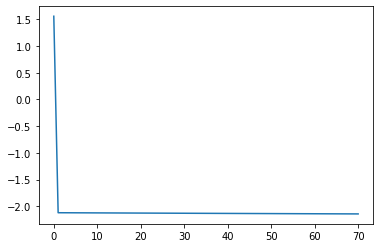

75


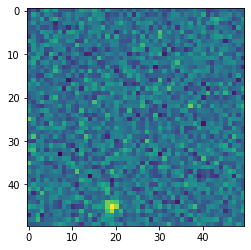

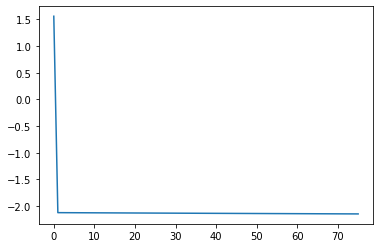

80


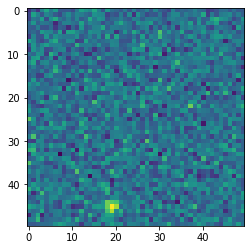

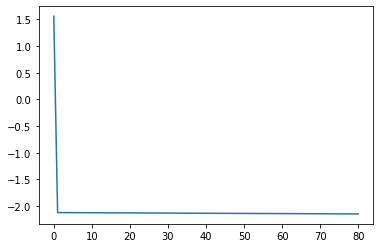

85


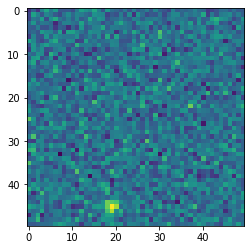

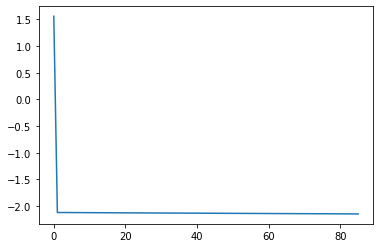

90


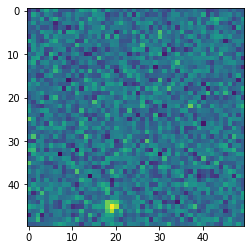

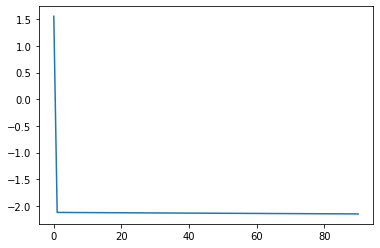

95


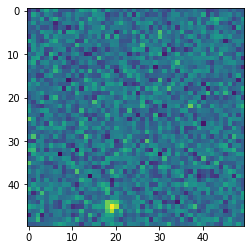

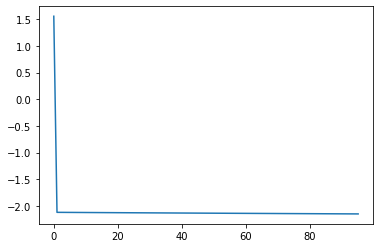

100


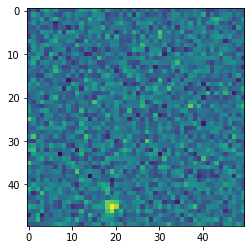

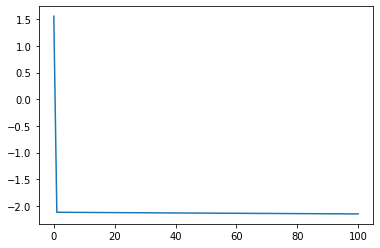

105


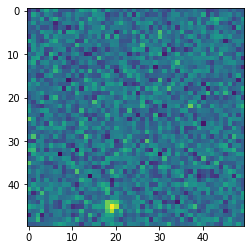

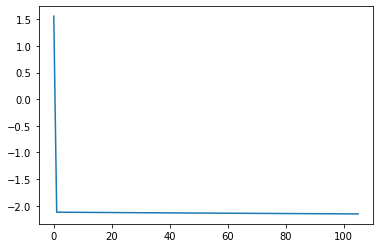

110


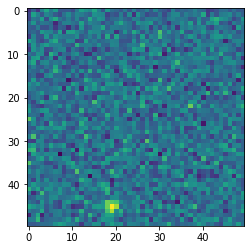

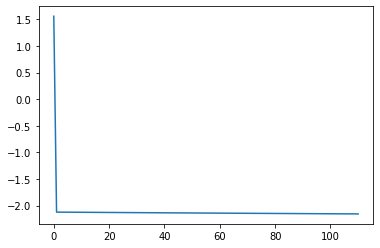

115


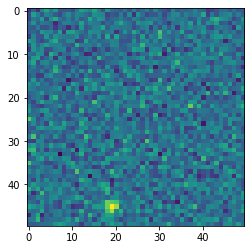

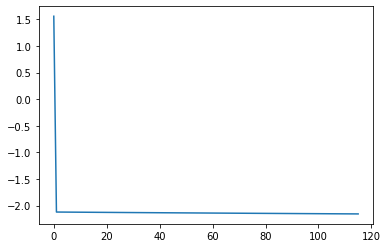

120


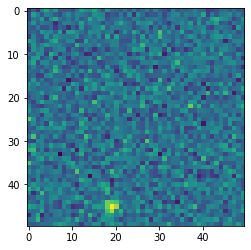

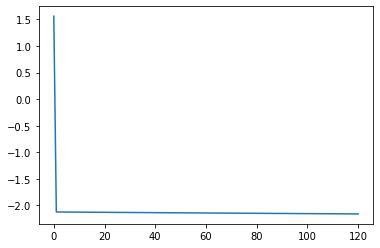

125


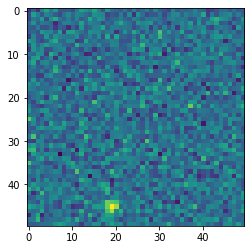

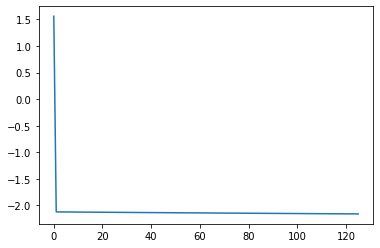

130


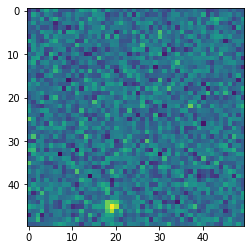

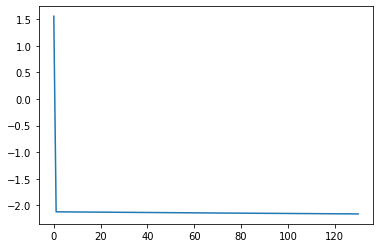

135


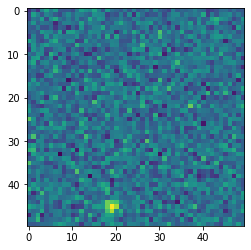

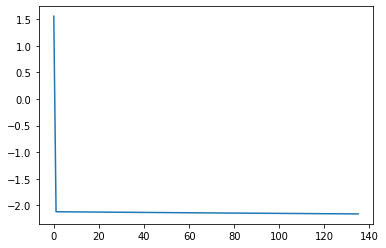

140


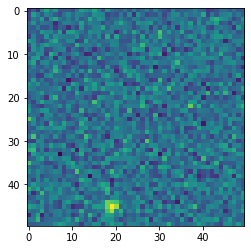

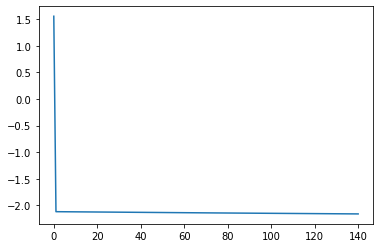

145


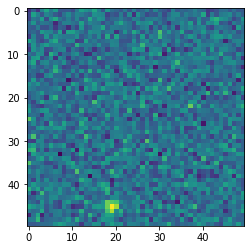

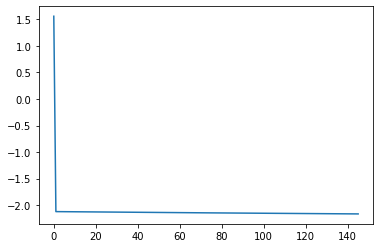

In [99]:
#https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/generate_class_specific_samples.py
from torch.autograd import Variable

molecule = Variable(torch.randn(1,9,50,50,50).to(device),requires_grad=True)
model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args['TRANSF'],device=device,sigma_0 = args['SIGMA'],sigma_trainable = args['SIGMA_TRAIN'], x_trainable=True, x_input=torch.randn(1,9,50,50,50))
model=model.to(device)
model.load_state_dict(torch.load(os.path.join(MODEL_PATH,'checkpoint.pt')))
model.x_input=Parameter(molecule,requires_grad=True)
target=torch.zeros(29)
# target[13]=1
target[15]=1

target = target.to(device)

optimizer = torch.optim.SGD([model.x_input], lr=5e1)
losses=[]

for epoch in range(150):
    
    output = model(model.x_input)
    # create mask to get rid of Nan's in target
    mask = (target == target)
    output_masked = torch.masked_select(output, mask).type_as(output)
    target_masked = torch.masked_select(target, mask).type_as(output)
    criterion=nn.MSELoss()
    loss = criterion(output_masked, target_masked)
    model.zero_grad()
    loss.backward()
    losses.append(loss.cpu().detach().numpy())
    optimizer.step()
    if epoch%5==0:
        print(epoch)
        plt.imshow(model.x_input.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
        plt.show()
        plt.plot(np.log(losses))
        plt.show()

In [109]:
output

tensor([[0.4304, 0.2246, 0.2704, 0.2086, 0.2539, 0.2731, 0.2176, 0.3425, 0.2024,
         0.2701, 0.4737, 0.2940, 0.3384, 0.2572, 0.2813, 0.2456, 0.2276, 0.2530,
         0.3674, 0.2851, 0.4113, 0.2408, 0.4043, 0.3972, 0.2396, 0.3152, 0.3766,
         0.3979, 0.2776]], device='cuda:0', grad_fn=<AddmmBackward>)

In [111]:
target

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

## Optimizer Adam with weight decay

0


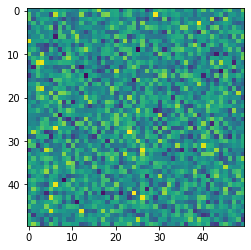

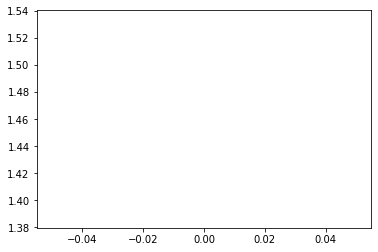

5


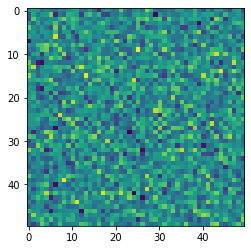

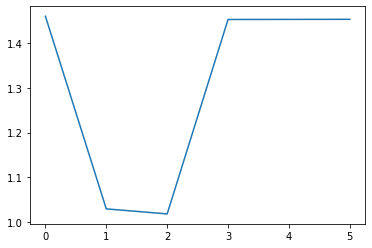

10


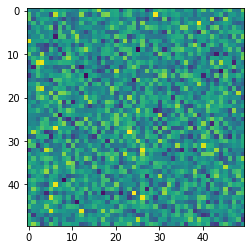

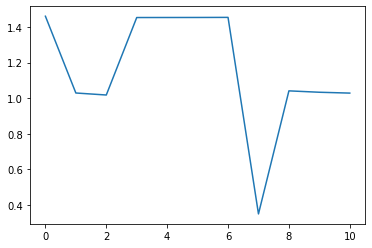

In [119]:
#https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/generate_class_specific_samples.py
from torch.autograd import Variable

molecule = Variable(torch.randn(1,9,50,50,50).to(device),requires_grad=True)
model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args['TRANSF'],device=device,sigma_0 = args['SIGMA'],sigma_trainable = args['SIGMA_TRAIN'], x_trainable=True, x_input=torch.randn(1,9,50,50,50))
model=model.to(device)
model.load_state_dict(torch.load(os.path.join(MODEL_PATH,'checkpoint.pt')))
model.x_input=Parameter(molecule,requires_grad=True)
target=torch.zeros(29)
# target[13]=1
target[15]=1

target = target.to(device)

optimizer = torch.optim.SGD([model.x_input], lr=1e3)
optimizer = torch.optim.Adam([model.x_input], lr=1e3, weight_decay=1e-1)
losses=[]

for epoch in range(11):
    
    output = model(model.x_input)
    # create mask to get rid of Nan's in target
    mask = (target == target)
    output_masked = torch.masked_select(output, mask).type_as(output)
    target_masked = torch.masked_select(target, mask).type_as(output)
    criterion=nn.MSELoss()
    loss = criterion(output_masked, target_masked)
    model.zero_grad()
    loss.backward()
    losses.append(loss.cpu().detach().numpy())
    optimizer.step()
    if epoch%5==0:
        print(epoch)
        plt.imshow(model.x_input.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
        plt.show()
        plt.plot(np.log(losses))
        plt.show()

In [120]:
losses

[array(4.3059435, dtype=float32),
 array(2.7989686, dtype=float32),
 array(2.767553, dtype=float32),
 array(4.274856, dtype=float32),
 array(4.275655, dtype=float32),
 array(4.2764707, dtype=float32),
 array(4.278514, dtype=float32),
 array(1.4199922, dtype=float32),
 array(2.8327453, dtype=float32),
 array(2.8107424, dtype=float32),
 array(2.7973633, dtype=float32)]

In [121]:
output.argmin()

tensor(8, device='cuda:0')

In [122]:
output

tensor([[2.3109, 1.2384, 1.5232, 1.1621, 1.3875, 1.4218, 1.1085, 1.7795, 1.0681,
         1.4325, 2.6171, 1.5897, 1.8277, 1.3816, 1.5565, 1.2343, 1.2079, 1.3915,
         2.0258, 1.5392, 2.2118, 1.2126, 2.1984, 2.1494, 1.3033, 1.7478, 2.0760,
         2.2168, 1.5098]], device='cuda:0', grad_fn=<AddmmBackward>)

In [117]:
target

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

0


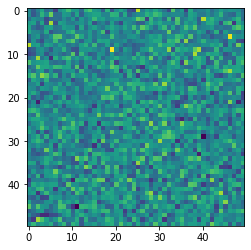

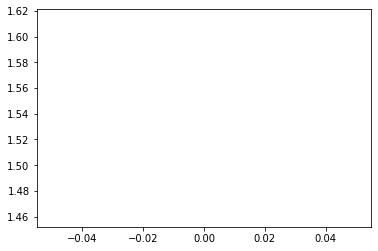

5


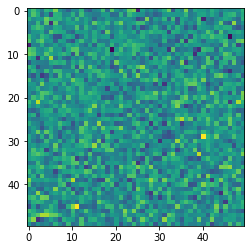

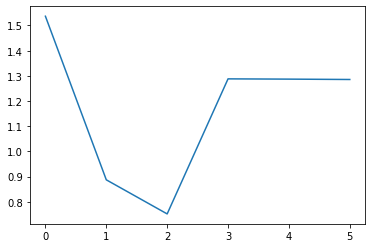

10


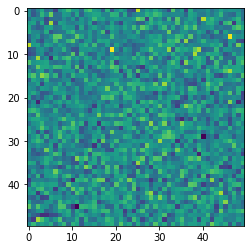

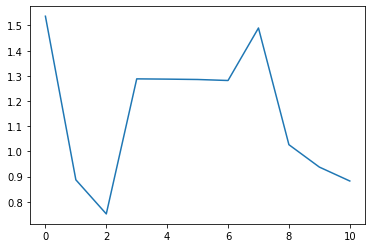

15


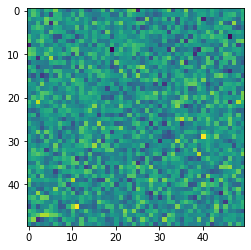

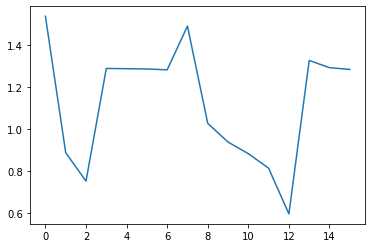

20


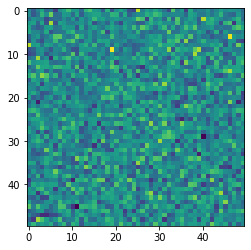

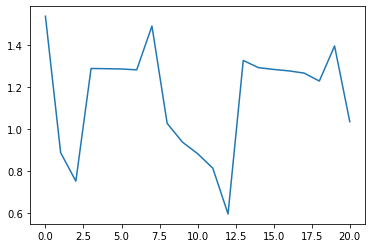

25


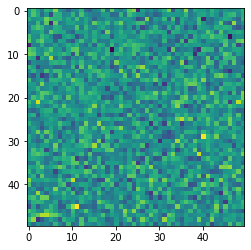

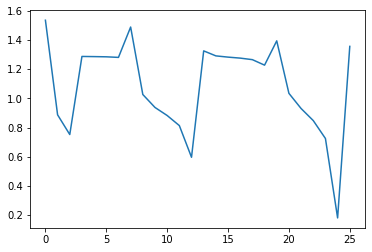

30


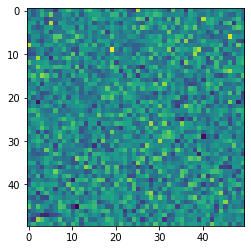

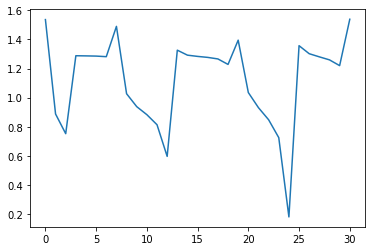

35


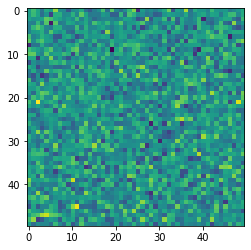

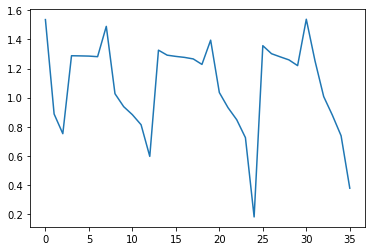

40


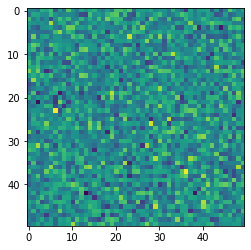

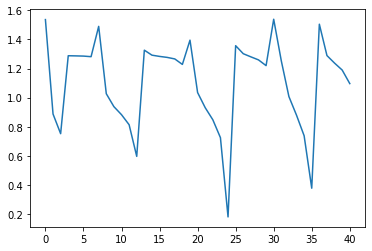

45


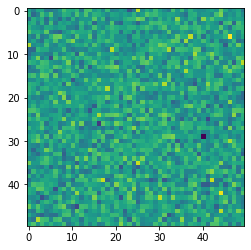

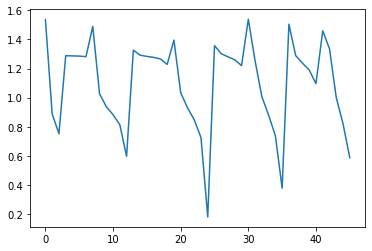

50


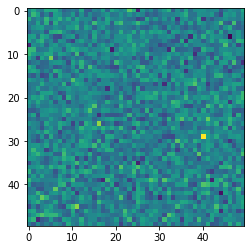

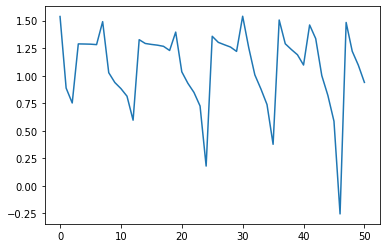

55


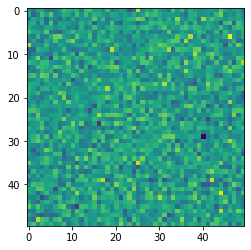

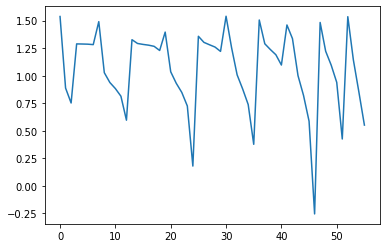

60


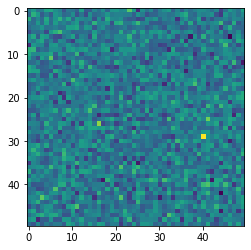

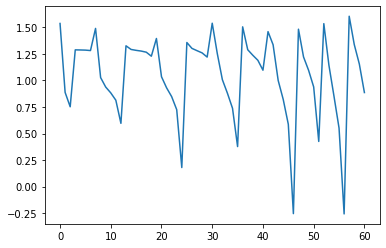

65


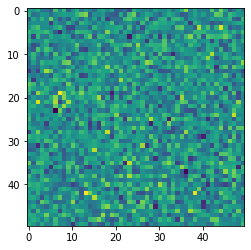

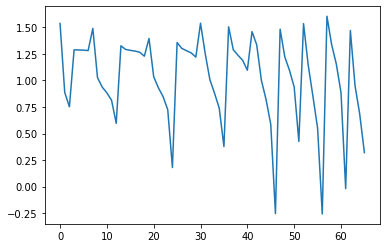

70


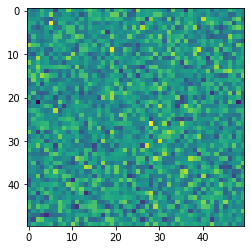

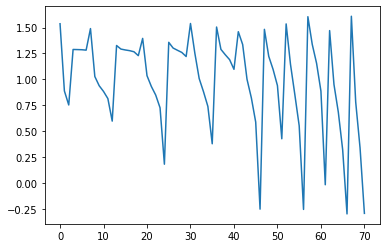

75


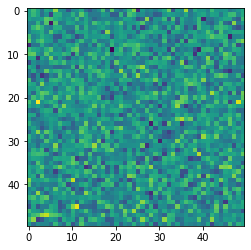

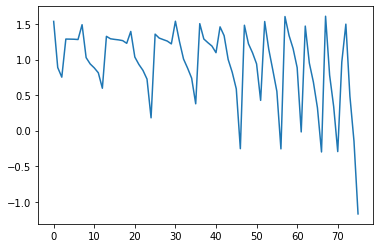

80


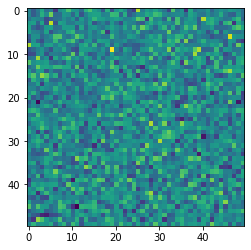

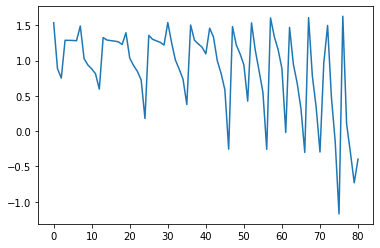

85


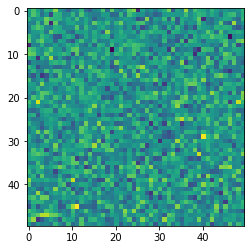

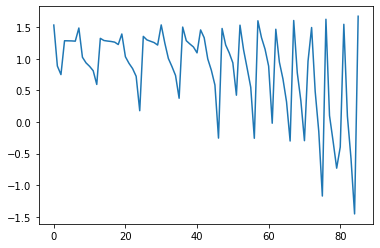

90


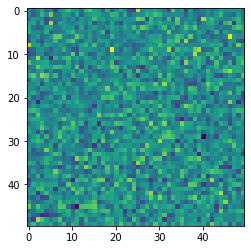

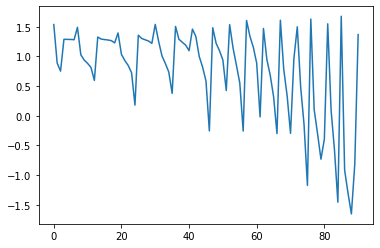

95


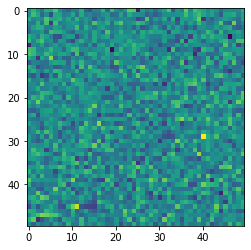

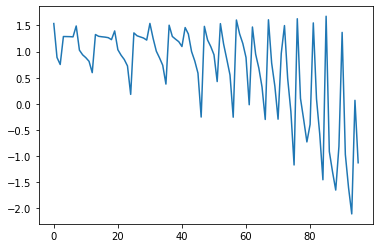

100


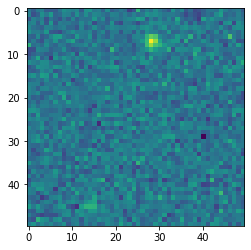

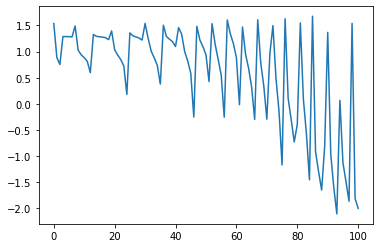

105


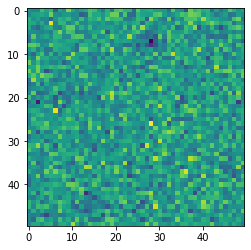

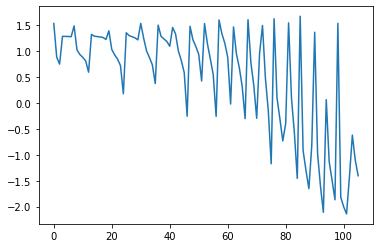

110


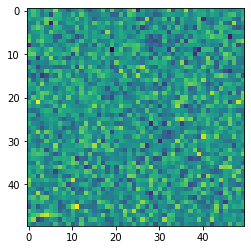

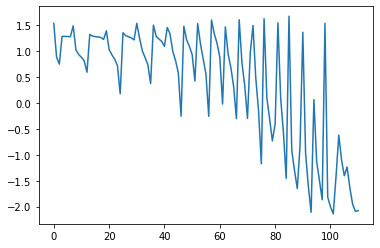

115


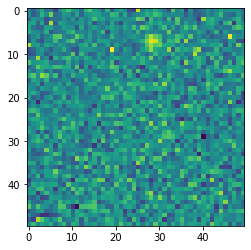

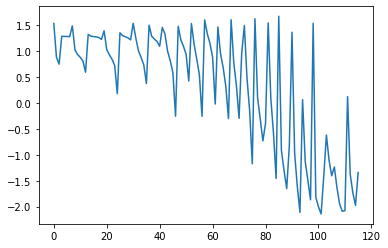

120


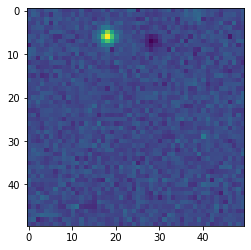

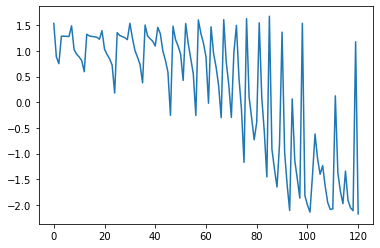

125


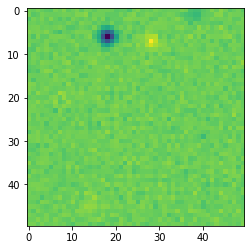

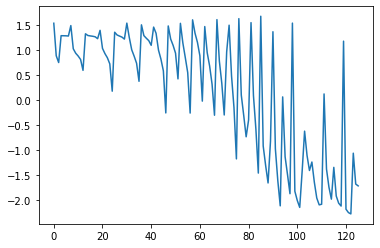

130


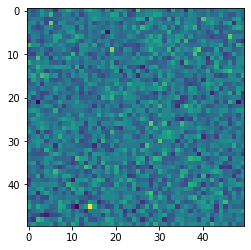

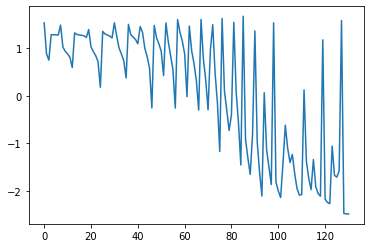

135


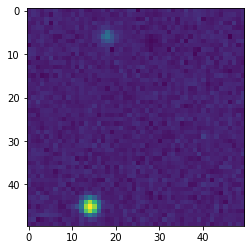

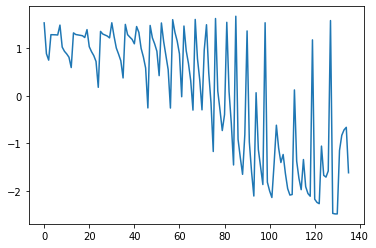

140


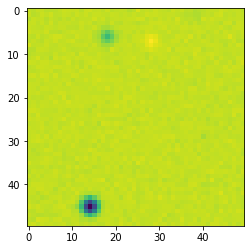

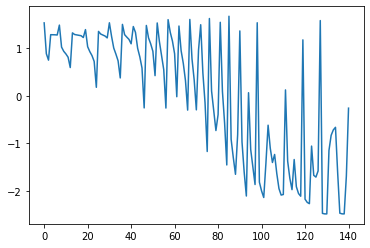

145


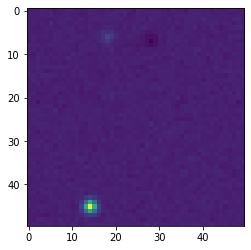

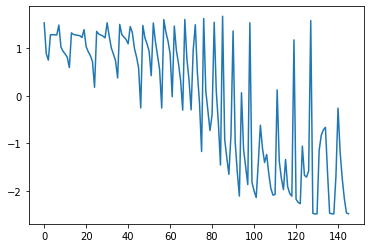

In [135]:
#https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/generate_class_specific_samples.py
from torch.autograd import Variable

molecule = Variable(torch.randn(1,9,50,50,50).to(device),requires_grad=True)
model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args['TRANSF'],device=device,sigma_0 = args['SIGMA'],sigma_trainable = args['SIGMA_TRAIN'], x_trainable=True, x_input=torch.randn(1,9,50,50,50))
model=model.to(device)
model.load_state_dict(torch.load(os.path.join(MODEL_PATH,'checkpoint.pt')))
model.x_input=Parameter(molecule,requires_grad=True)
target=torch.zeros(29)
# target[13]=1
target[15]=1

target = target.to(device)

optimizer = torch.optim.SGD([model.x_input], lr=1e3)
optimizer = torch.optim.Adam([model.x_input], lr=1e2, weight_decay=1e-1)
losses=[]

for epoch in range(150):
    
    output = model(model.x_input)
    # create mask to get rid of Nan's in target
    mask = (target == target)
    output_masked = torch.masked_select(output, mask).type_as(output)
    target_masked = torch.masked_select(target, mask).type_as(output)
    criterion=nn.MSELoss()
    loss = criterion(output_masked, target_masked)
    model.zero_grad()
    loss.backward()
    losses.append(loss.cpu().detach().numpy())
    optimizer.step()
    if epoch%5==0:
        print(epoch)
        plt.imshow(model.x_input.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
        plt.show()
        plt.plot(np.log(losses))
        plt.show()

0


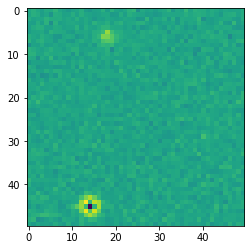

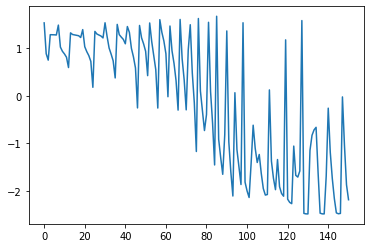

5


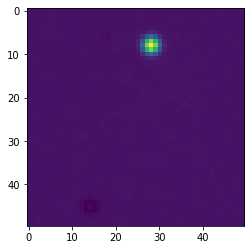

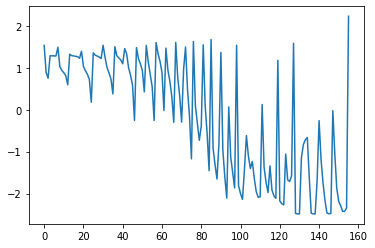

10


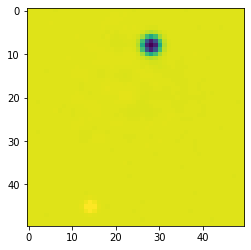

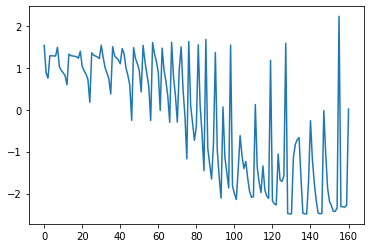

15


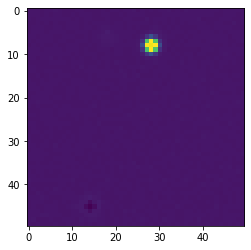

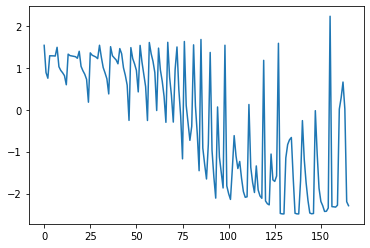

20


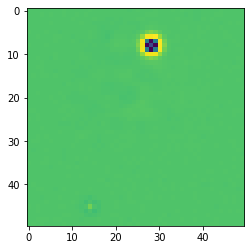

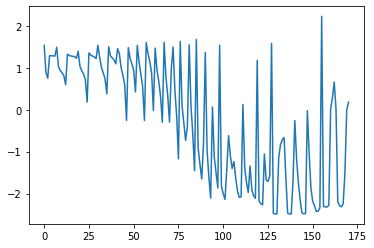

25


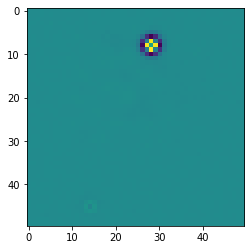

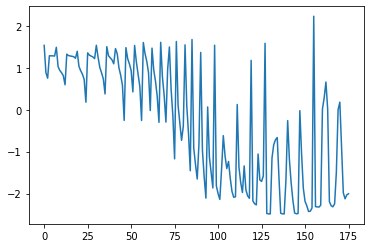

30


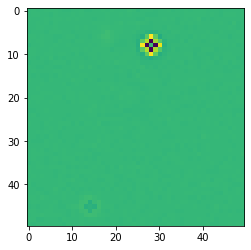

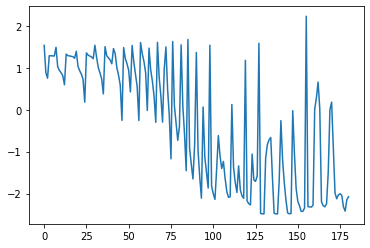

35


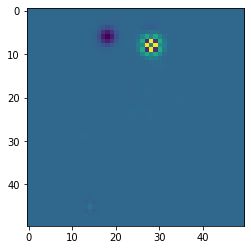

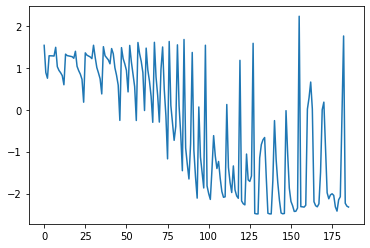

40


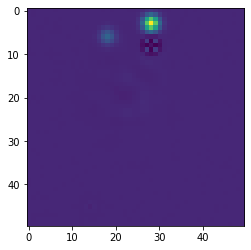

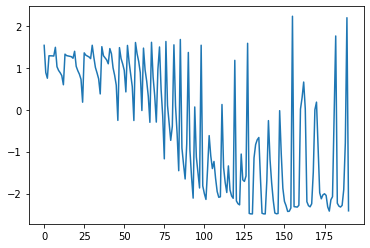

45


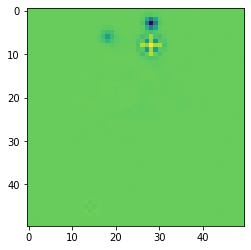

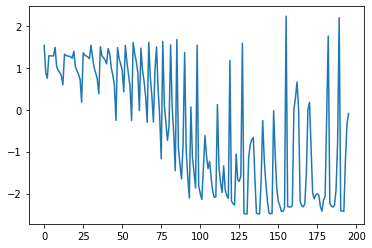

50


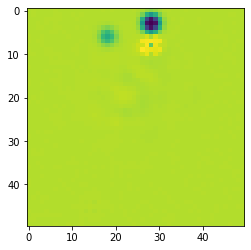

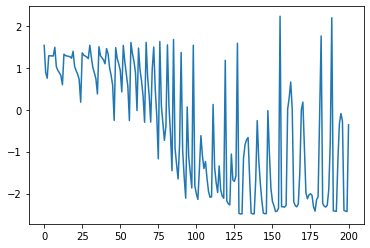

55


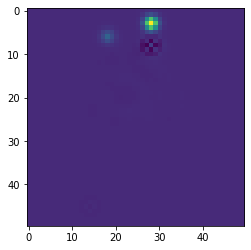

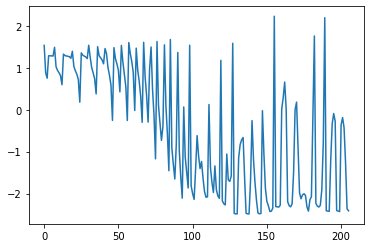

60


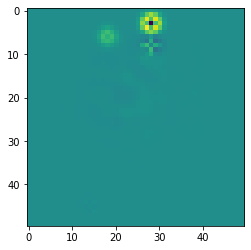

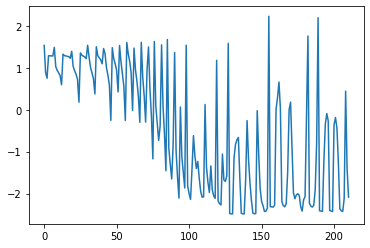

65


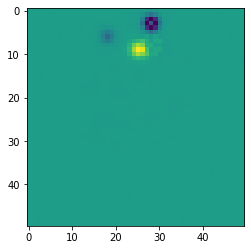

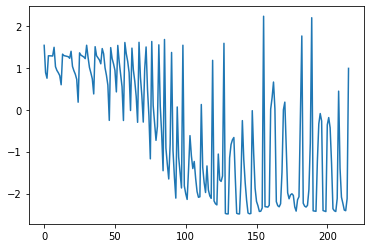

70


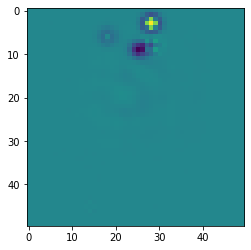

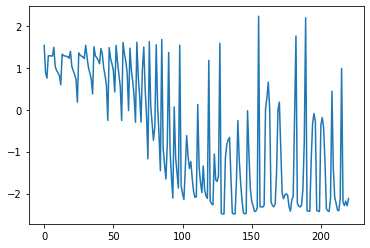

75


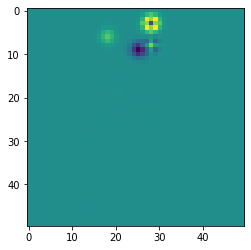

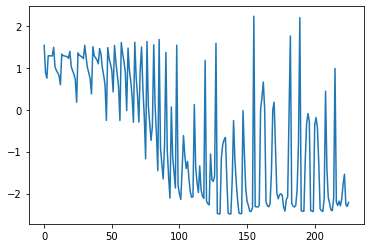

80


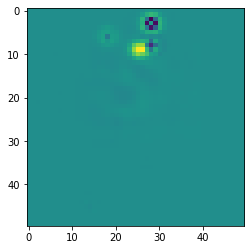

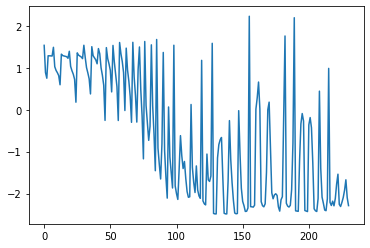

85


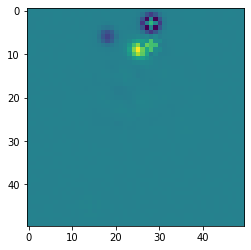

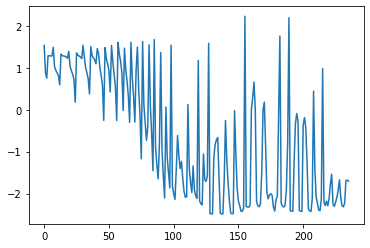

90


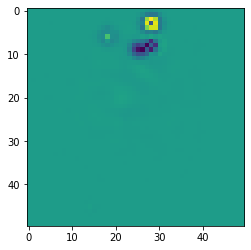

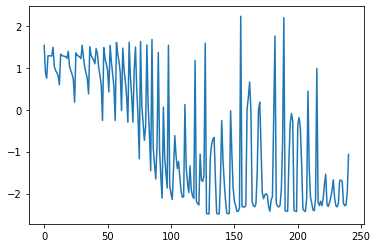

95


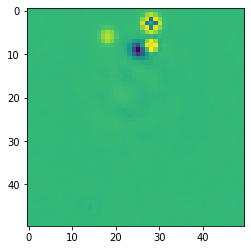

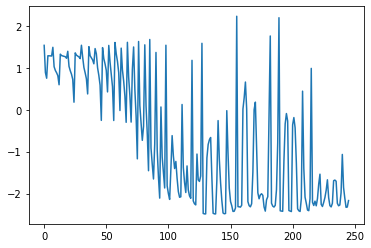

100


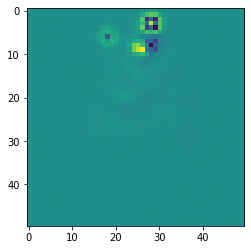

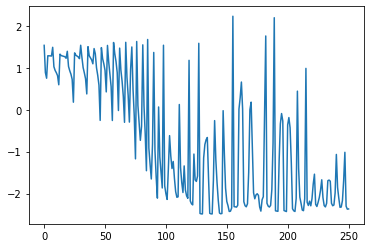

105


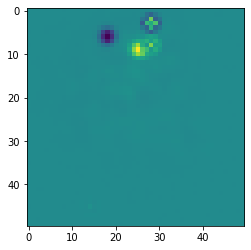

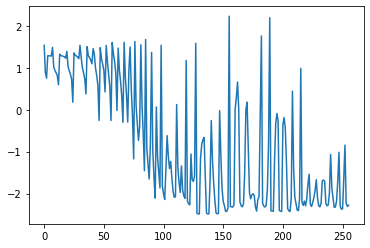

110


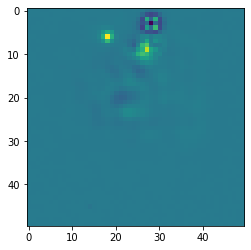

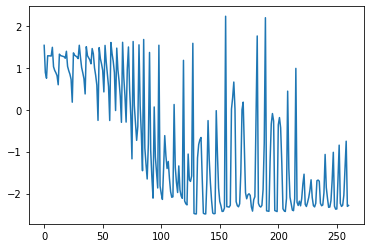

115


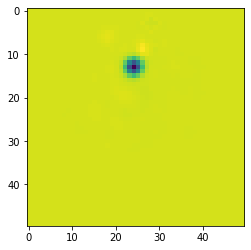

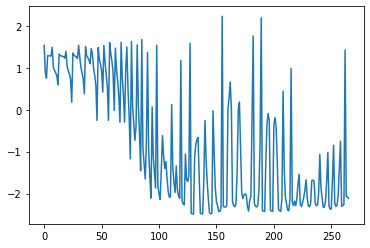

120


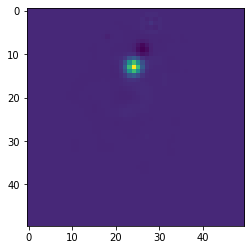

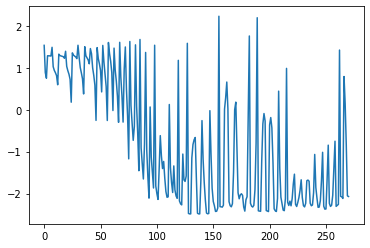

125


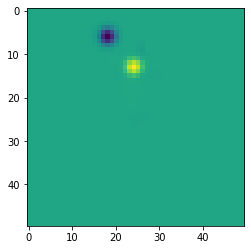

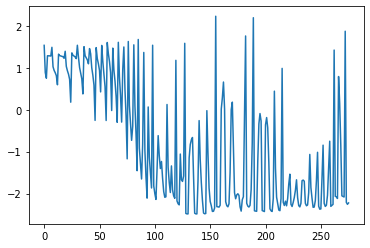

130


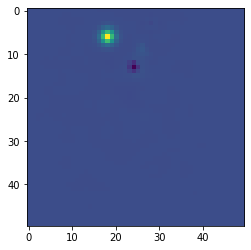

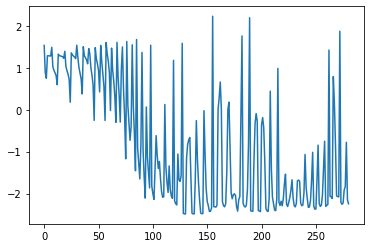

135


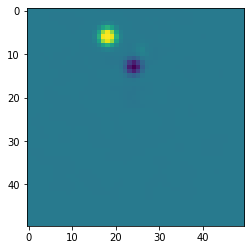

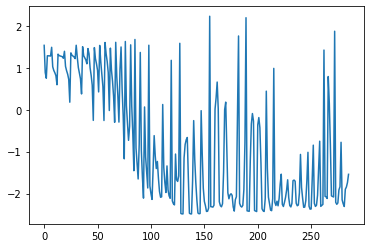

140


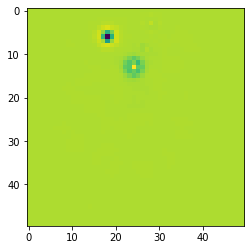

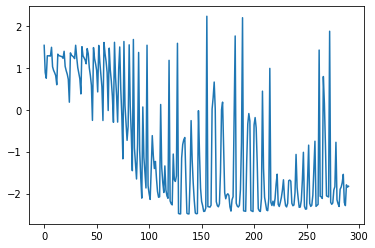

145


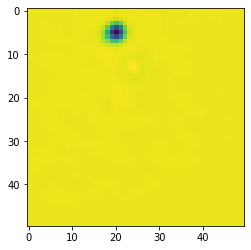

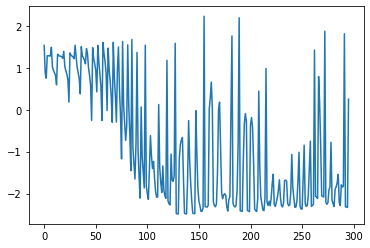

In [136]:
for epoch in range(150):
    
    output = model(model.x_input)
    # create mask to get rid of Nan's in target
    mask = (target == target)
    output_masked = torch.masked_select(output, mask).type_as(output)
    target_masked = torch.masked_select(target, mask).type_as(output)
    criterion=nn.MSELoss()
    loss = criterion(output_masked, target_masked)
    model.zero_grad()
    loss.backward()
    losses.append(loss.cpu().detach().numpy())
    optimizer.step()
    if epoch%5==0:
        print(epoch)
        plt.imshow(model.x_input.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
        plt.show()
        plt.plot(np.log(losses))
        plt.show()

In [137]:
torch.save(model.state_dict(),os.path.join(MODEL_PATH,'input_grad_adam_2_1_300.pt'))

random input 15


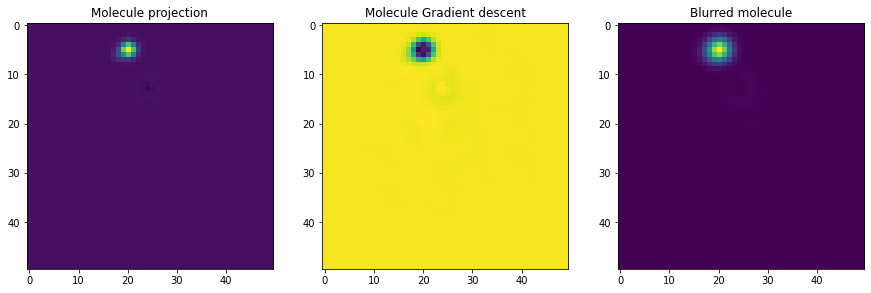

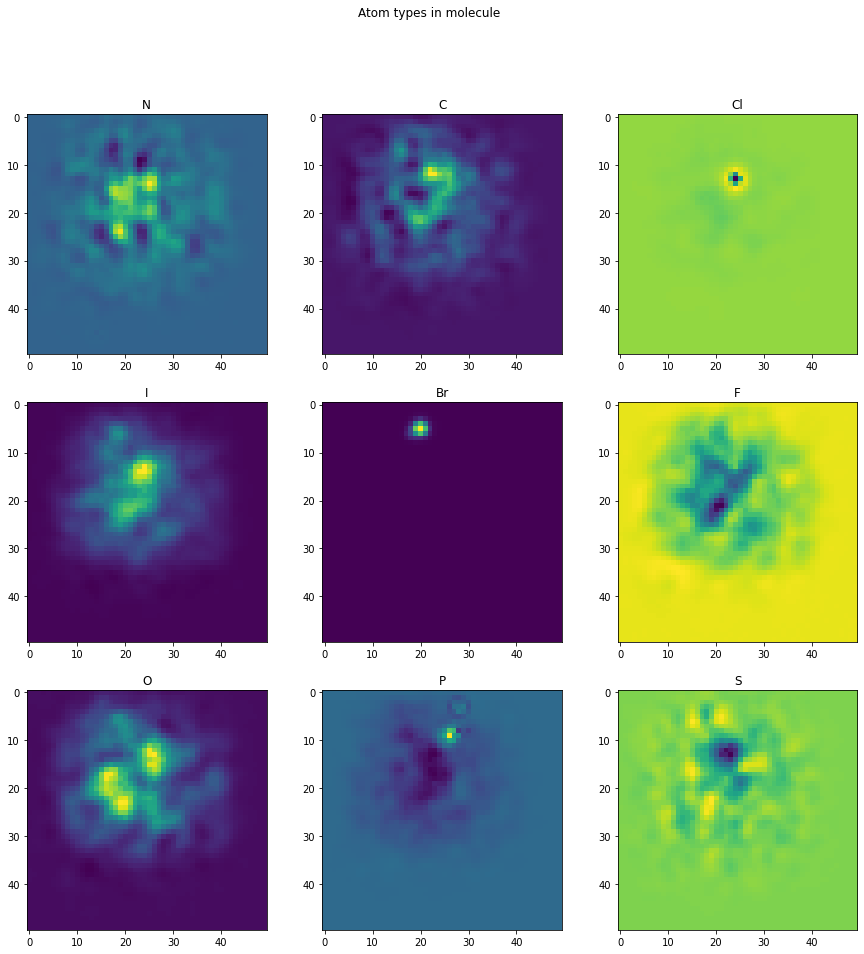

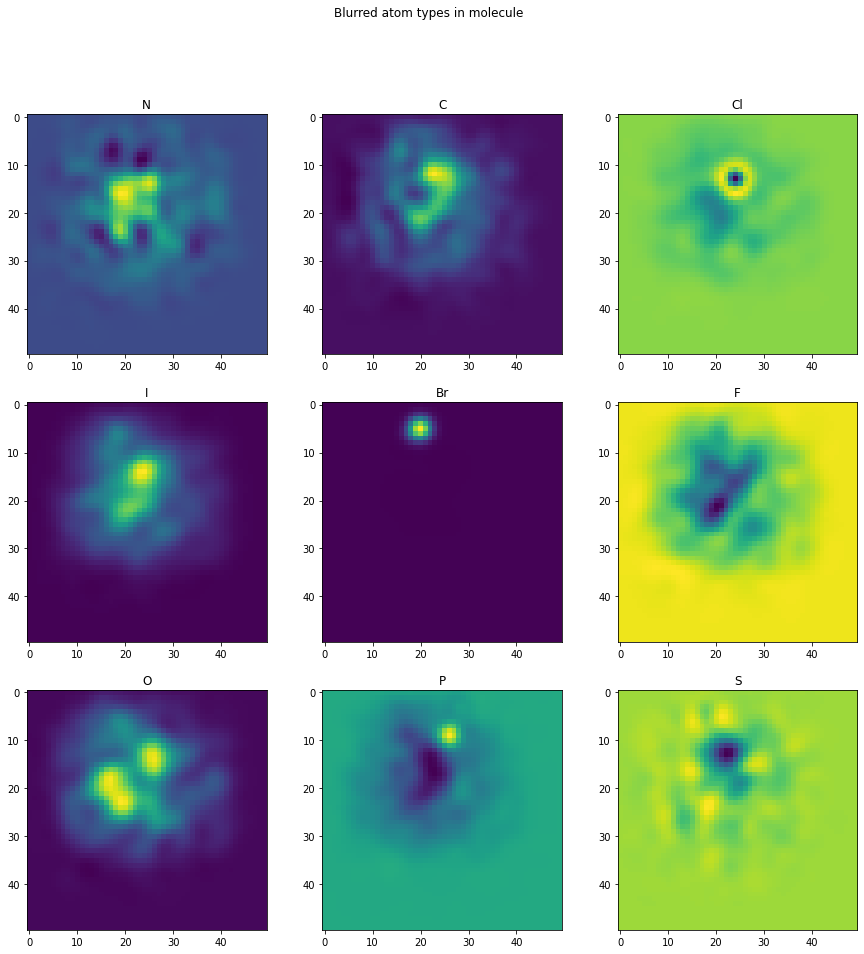

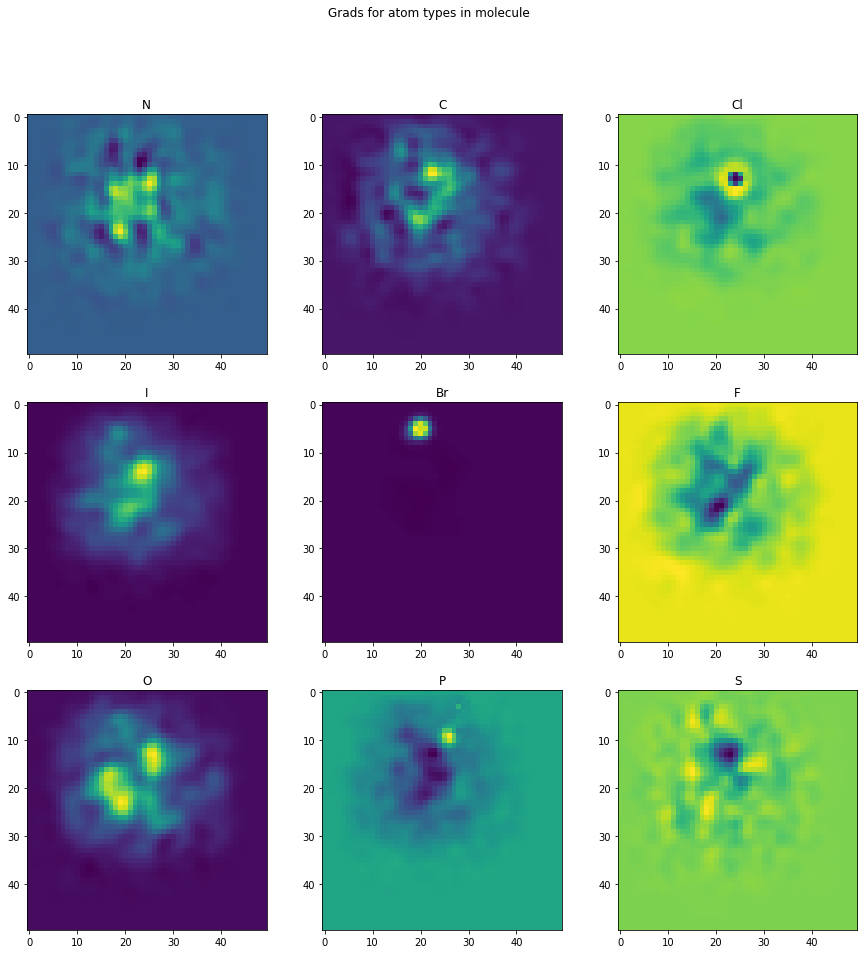

In [138]:
plot_visualization_input_as_parameter(model,elements,grad_step=10**3,name='random input 15')

0


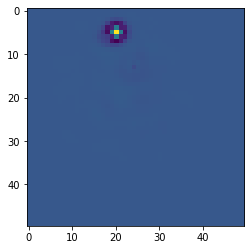

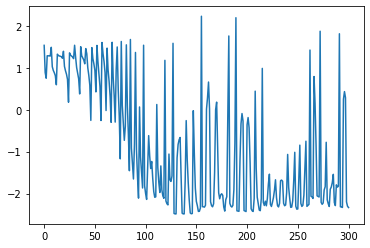

5


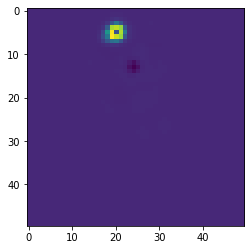

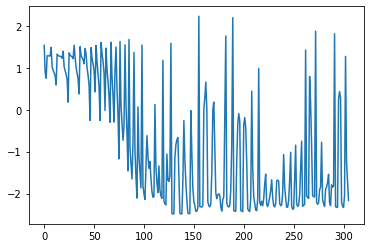

10


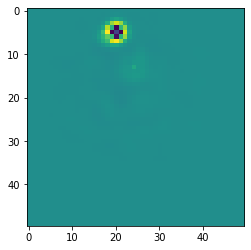

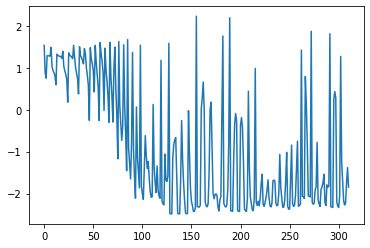

15


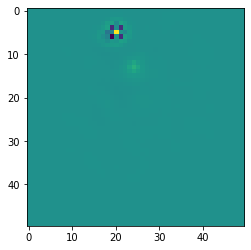

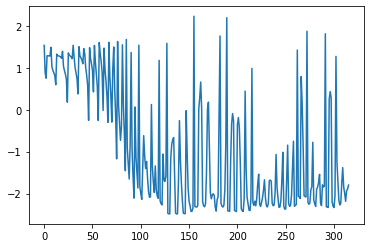

20


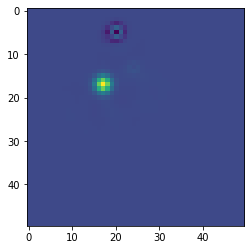

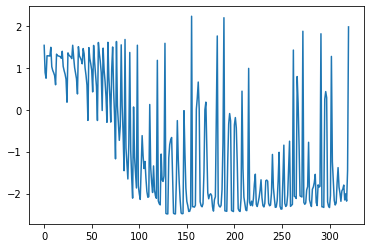

25


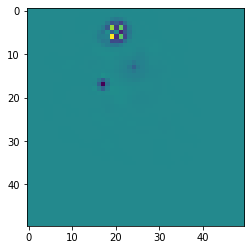

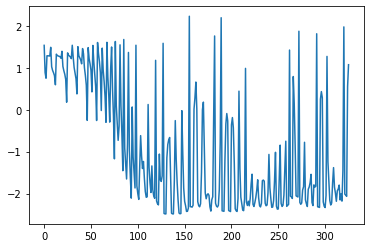

30


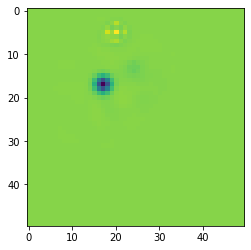

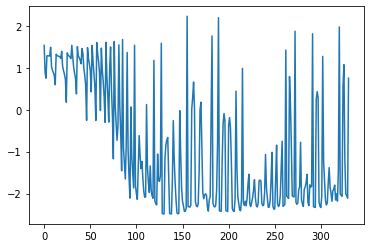

35


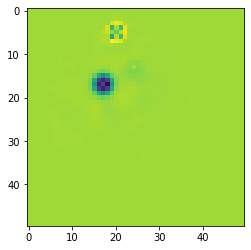

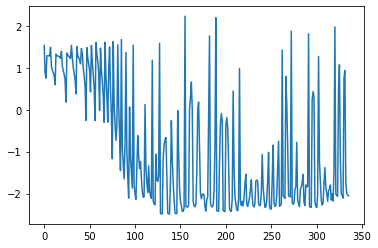

40


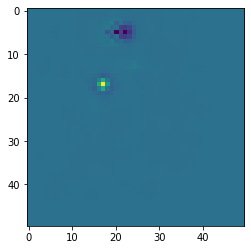

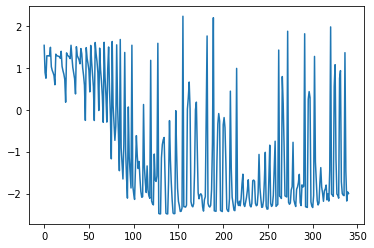

45


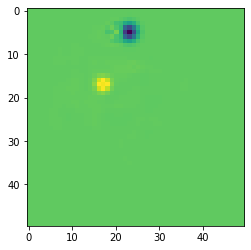

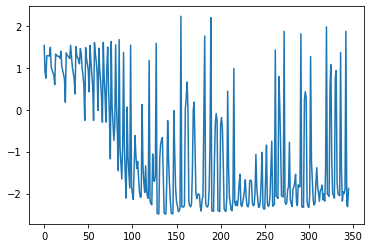

50


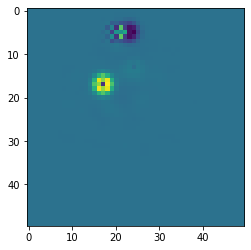

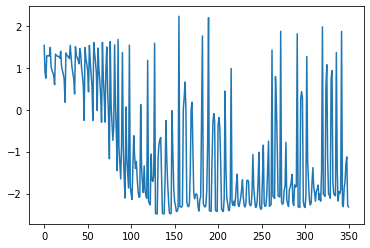

55


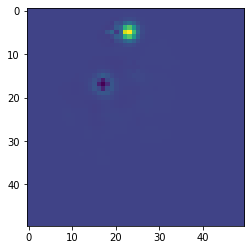

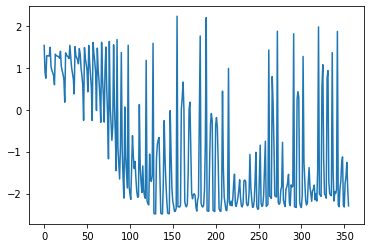

60


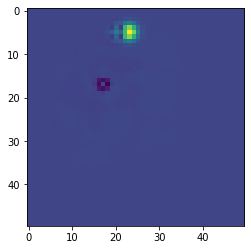

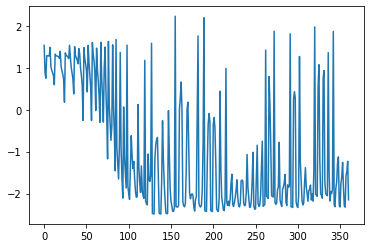

65


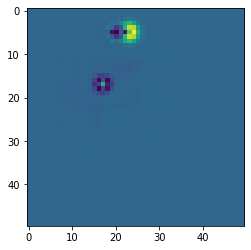

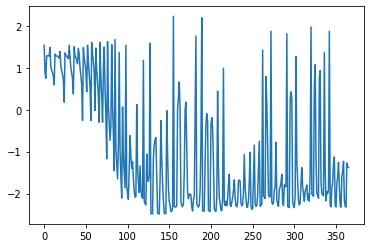

70


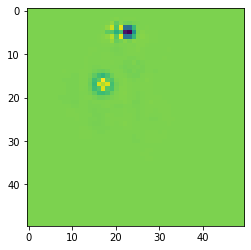

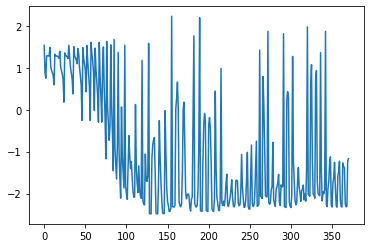

75


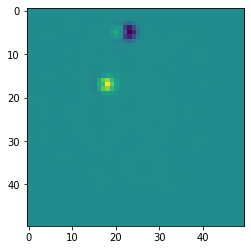

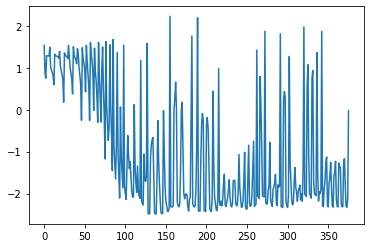

80


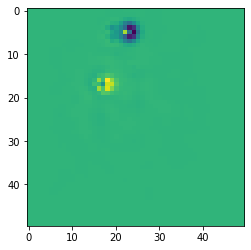

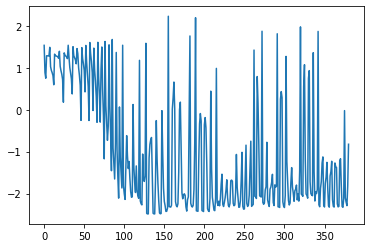

85


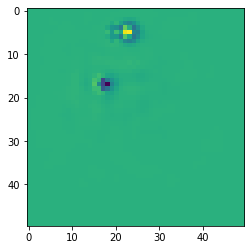

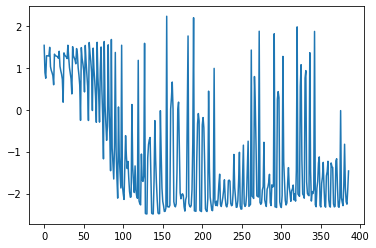

90


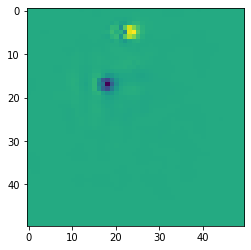

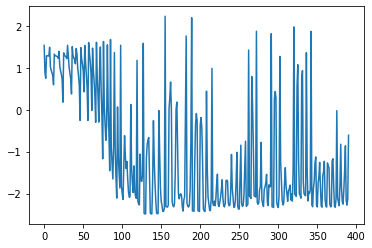

95


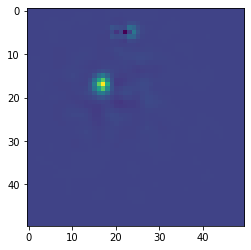

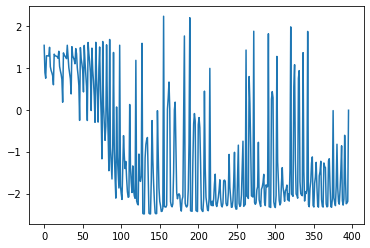

100


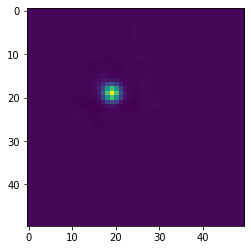

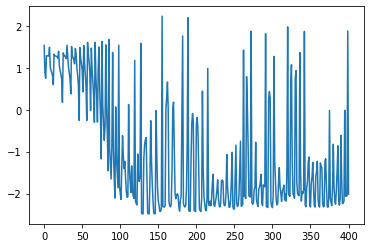

105


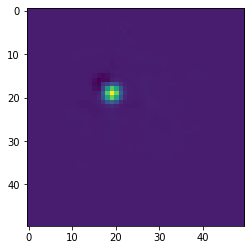

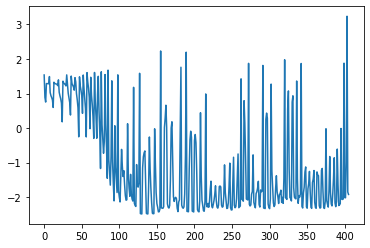

110


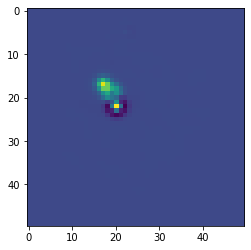

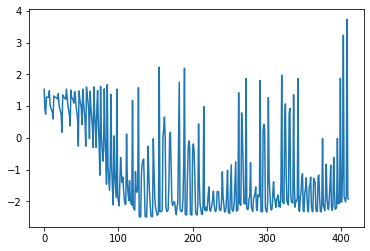

115


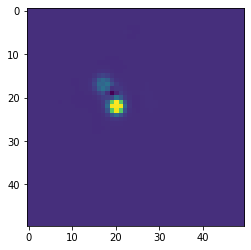

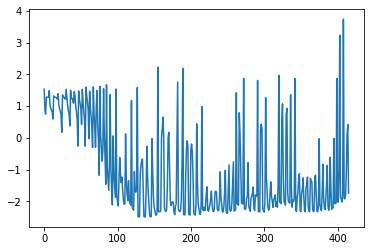

120


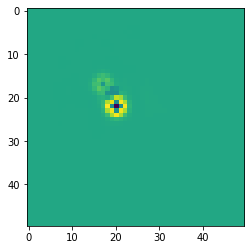

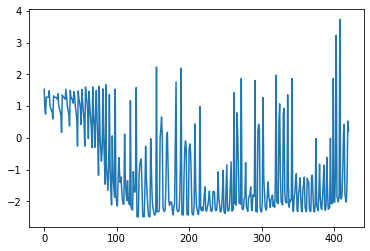

125


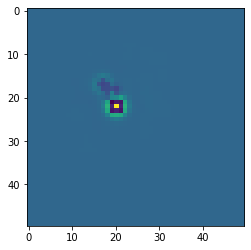

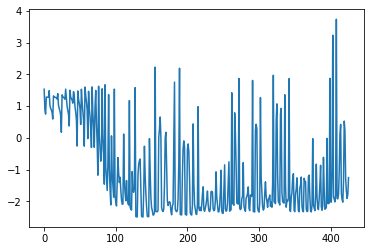

130


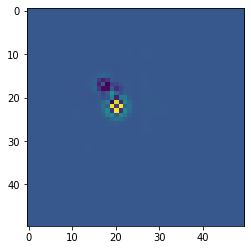

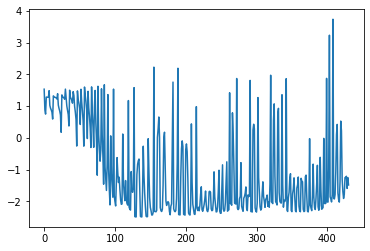

135


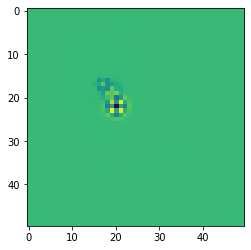

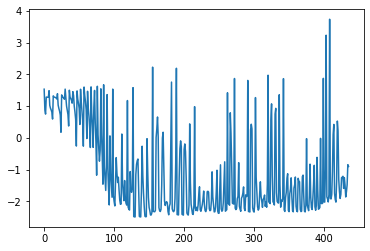

140


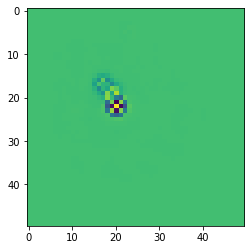

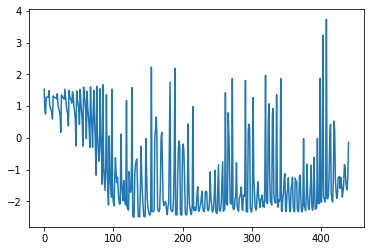

145


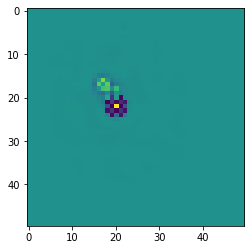

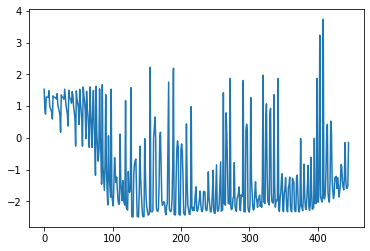

In [139]:
for epoch in range(150):
    
    output = model(model.x_input)
    # create mask to get rid of Nan's in target
    mask = (target == target)
    output_masked = torch.masked_select(output, mask).type_as(output)
    target_masked = torch.masked_select(target, mask).type_as(output)
    criterion=nn.MSELoss()
    loss = criterion(output_masked, target_masked)
    model.zero_grad()
    loss.backward()
    losses.append(loss.cpu().detach().numpy())
    optimizer.step()
    if epoch%5==0:
        print(epoch)
        plt.imshow(model.x_input.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
        plt.show()
        plt.plot(np.log(losses))
        plt.show()

0


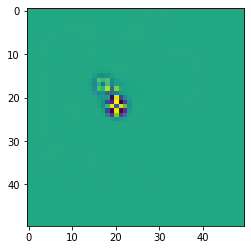

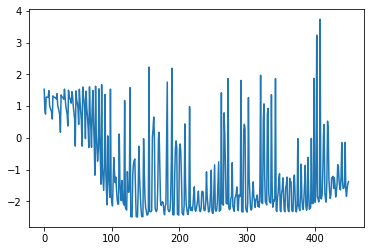

5


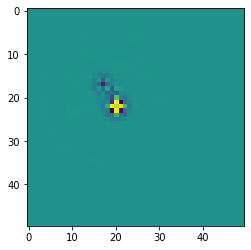

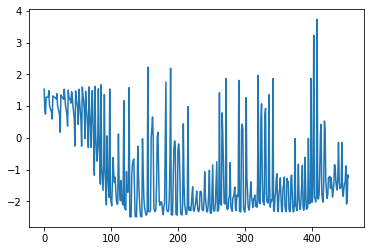

10


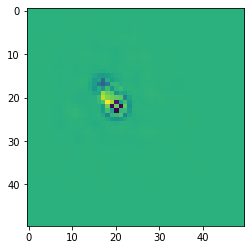

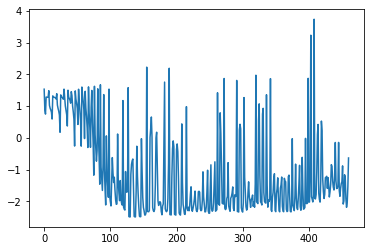

15


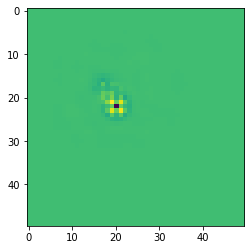

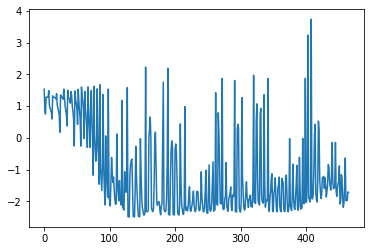

20


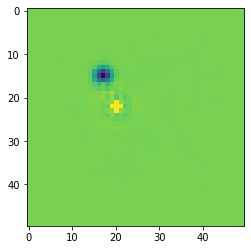

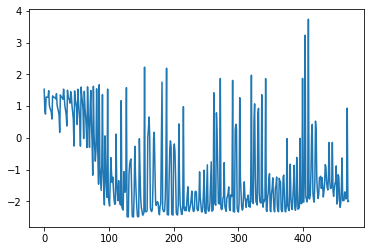

25


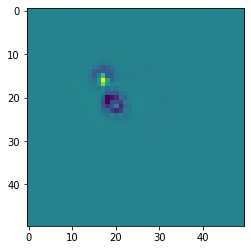

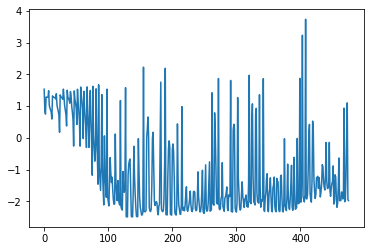

30


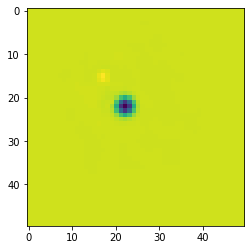

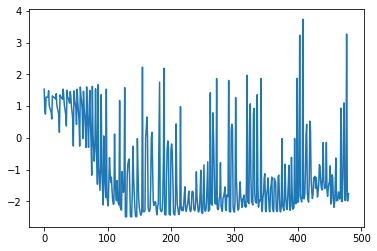

35


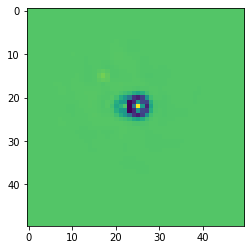

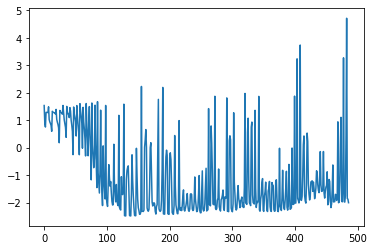

40


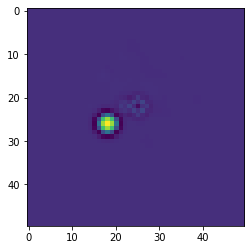

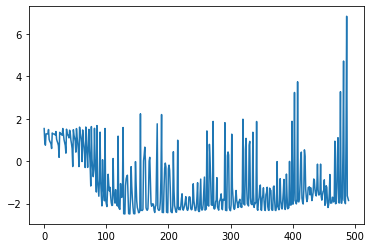

45


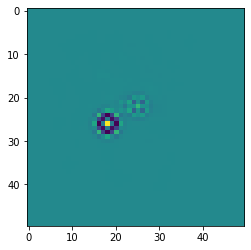

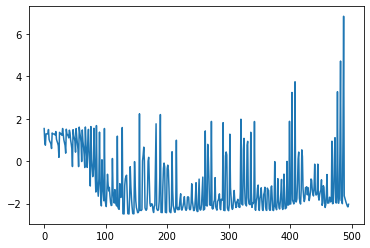

50


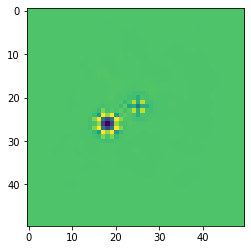

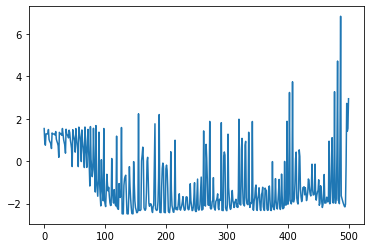

55


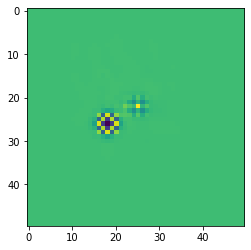

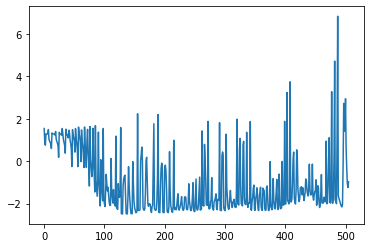

60


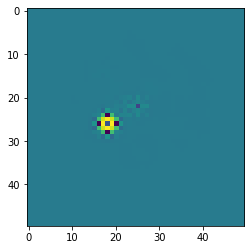

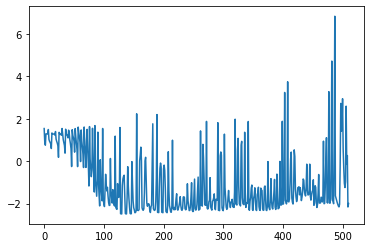

65


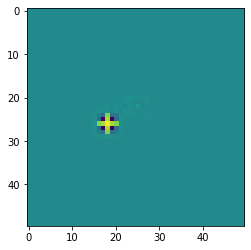

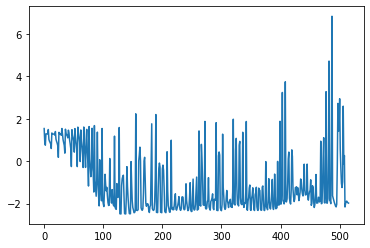

70


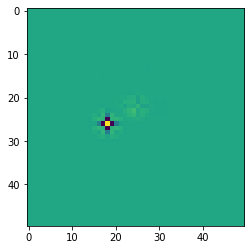

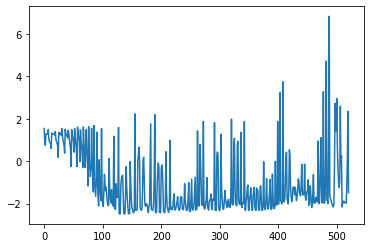

75


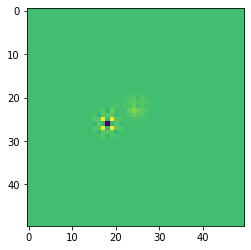

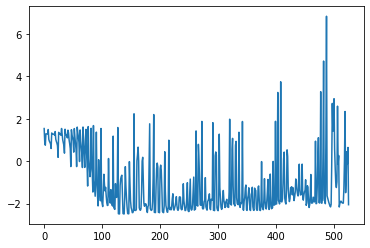

80


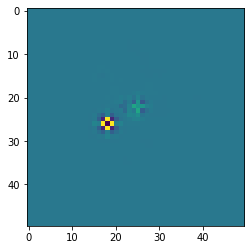

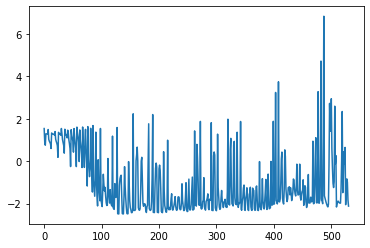

85


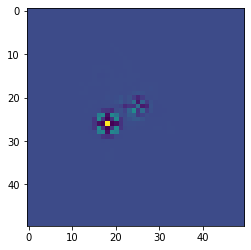

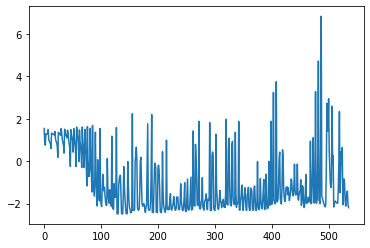

90


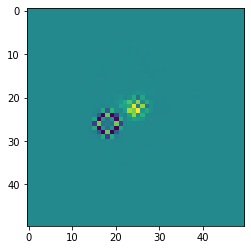

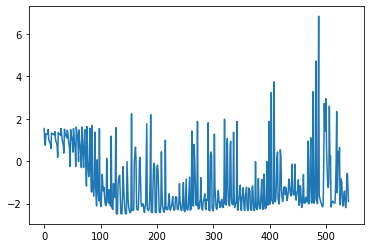

95


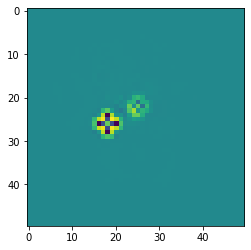

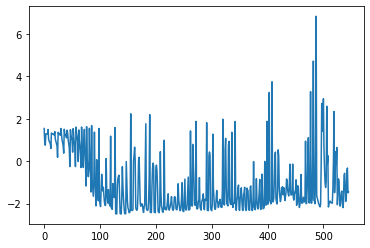

100


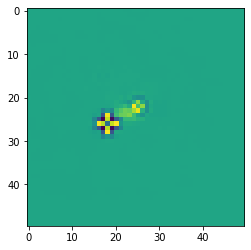

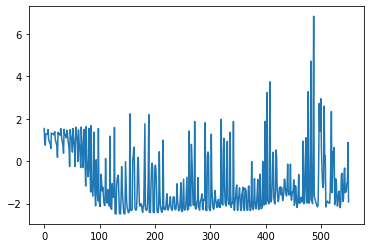

105


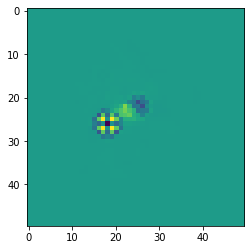

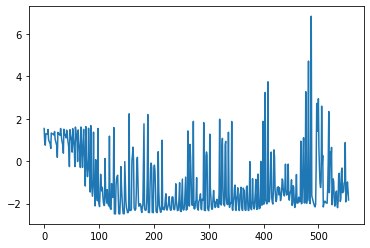

110


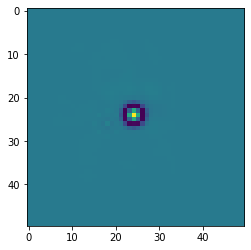

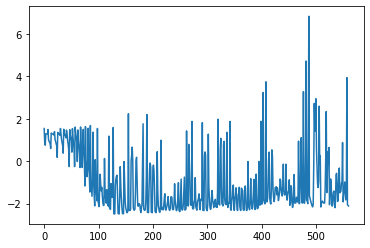

115


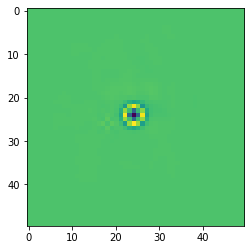

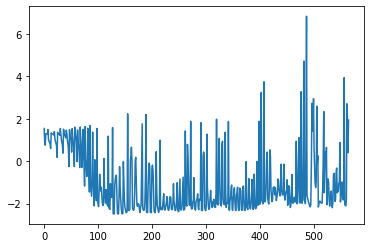

120


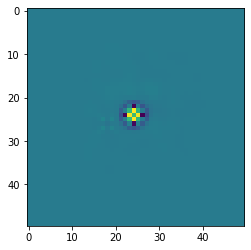

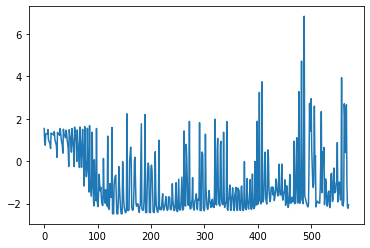

125


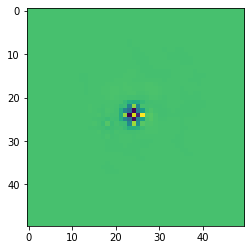

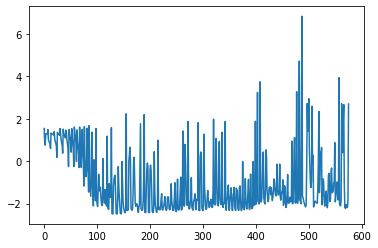

130


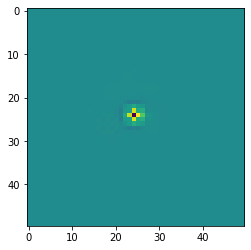

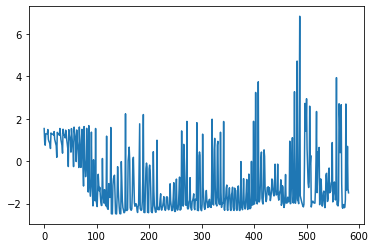

135


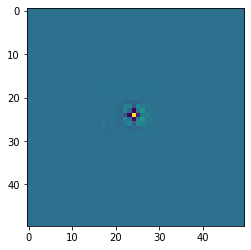

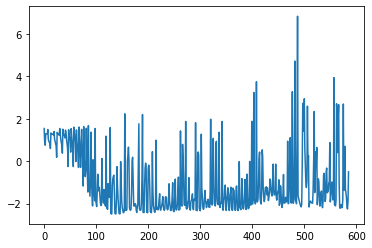

140


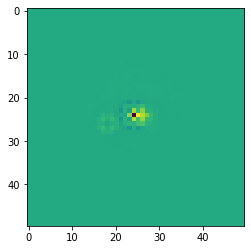

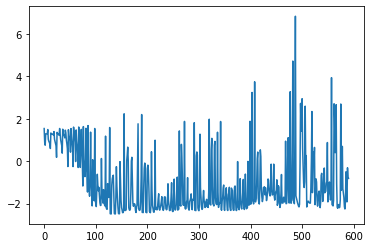

145


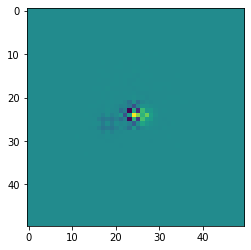

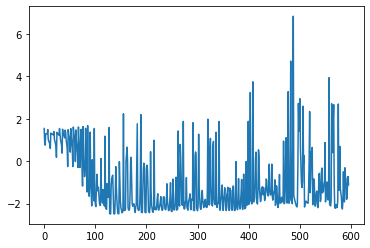

150


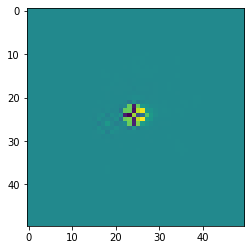

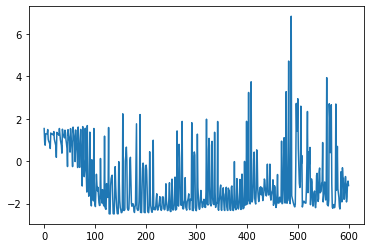

155


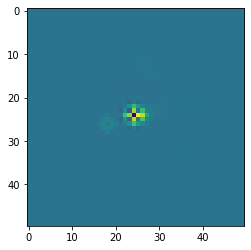

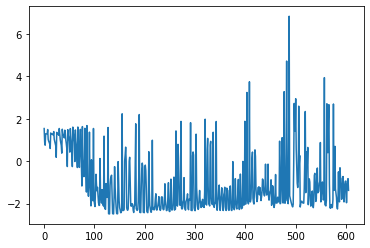

160


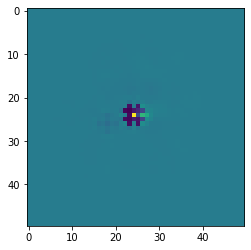

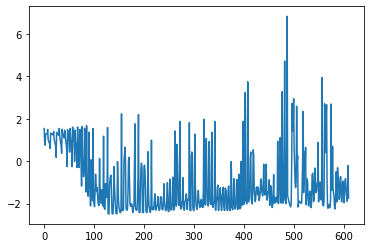

165


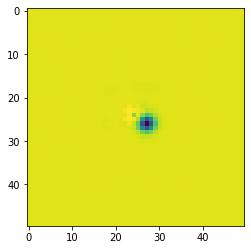

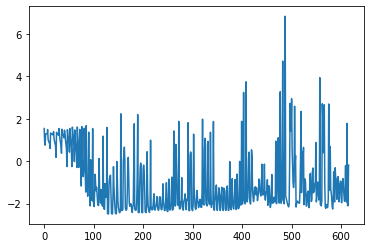

170


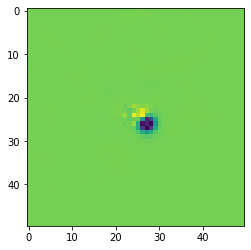

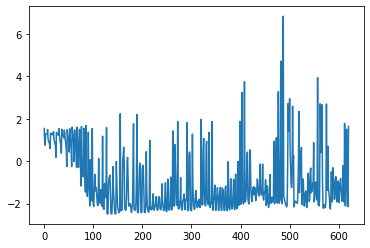

175


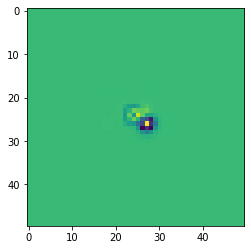

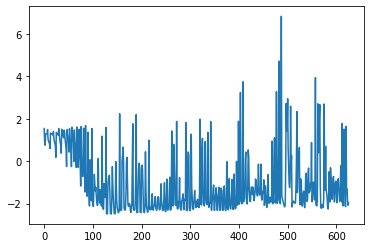

180


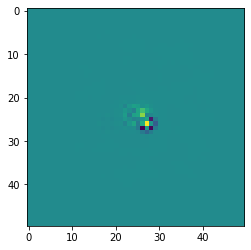

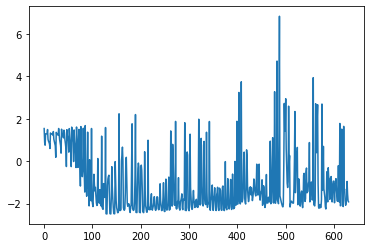

185


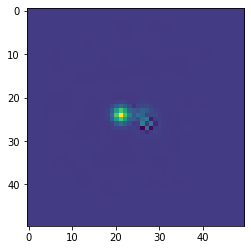

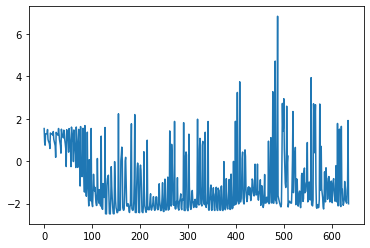

190


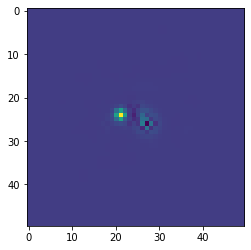

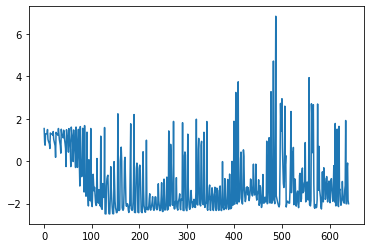

195


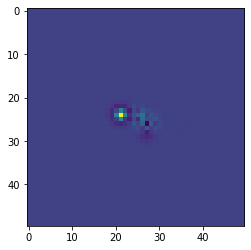

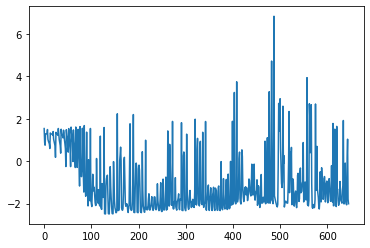

200


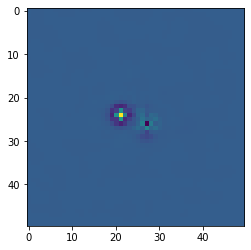

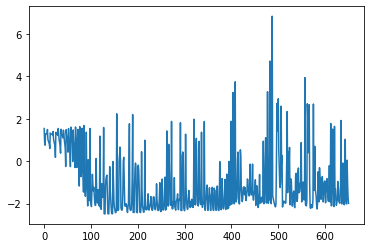

205


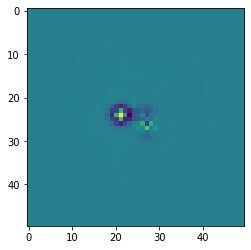

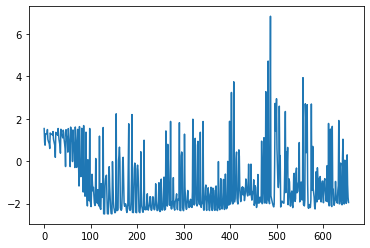

210


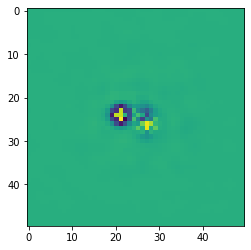

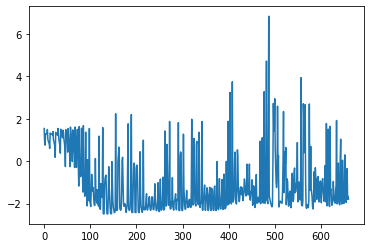

215


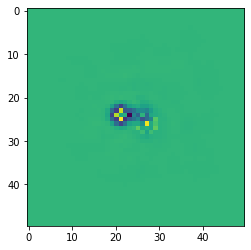

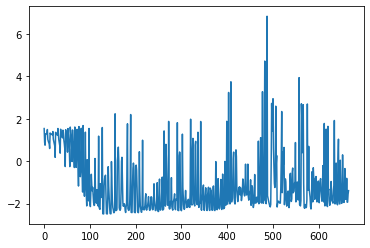

220


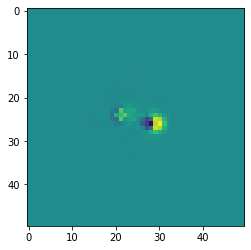

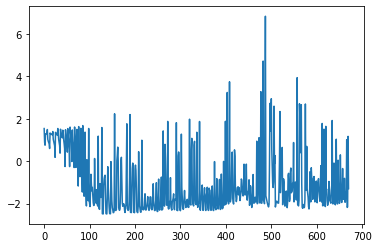

225


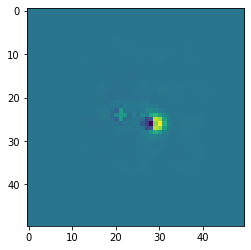

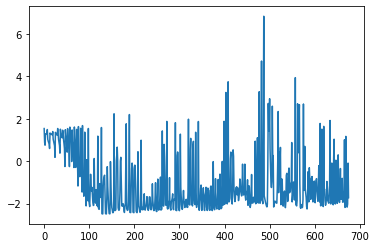

230


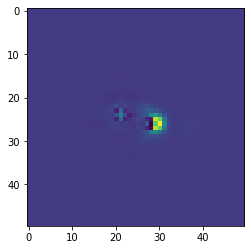

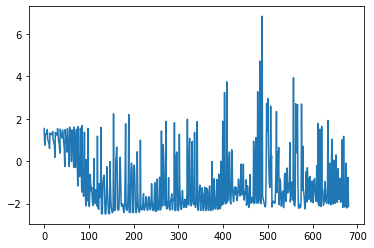

235


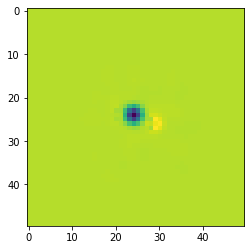

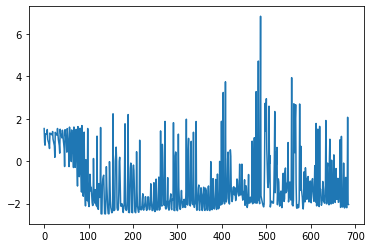

240


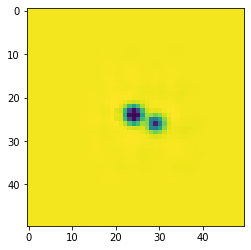

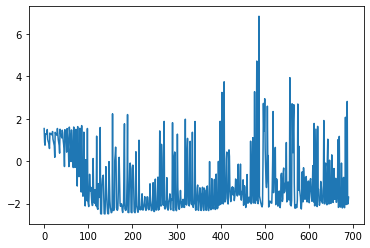

245


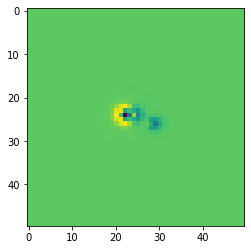

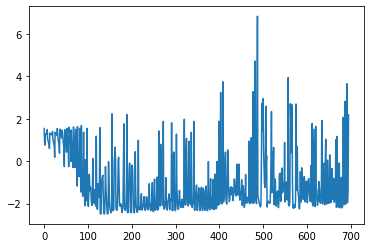

250


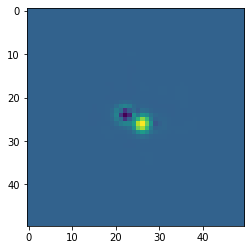

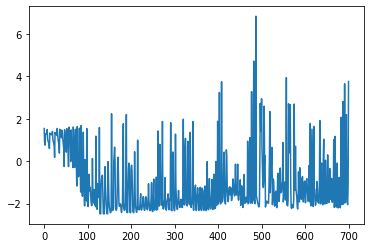

255


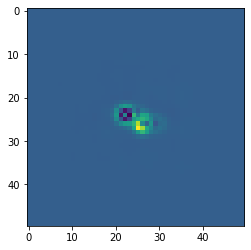

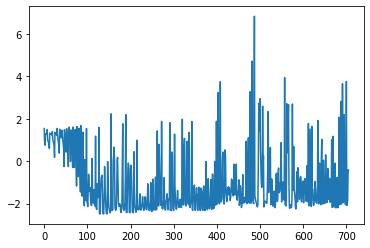

260


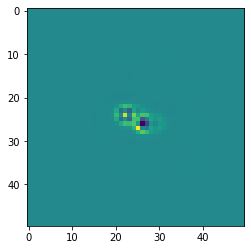

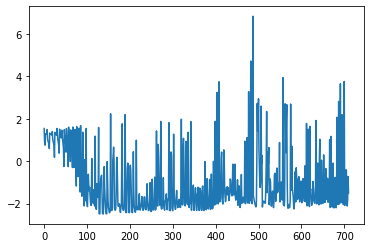

265


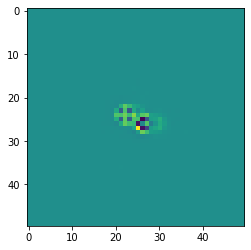

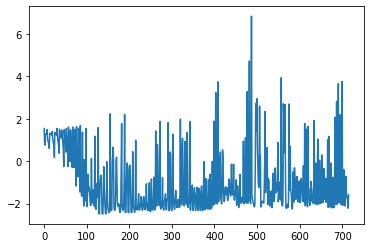

270


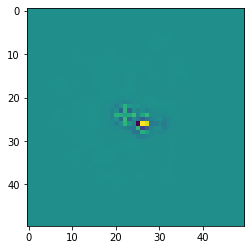

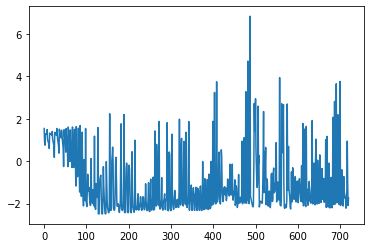

275


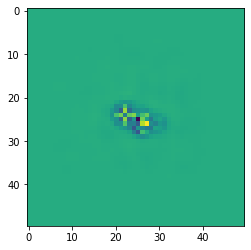

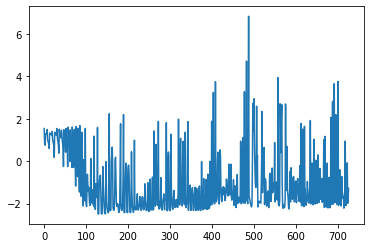

280


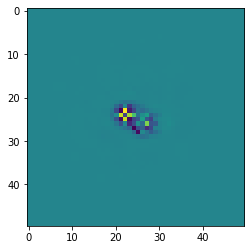

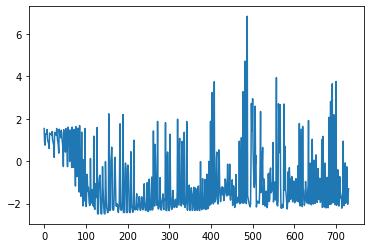

285


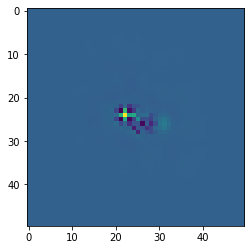

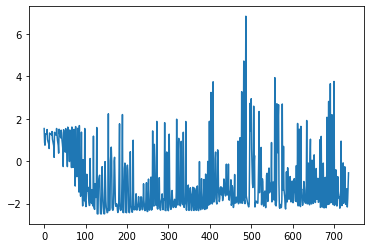

290


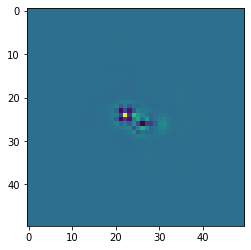

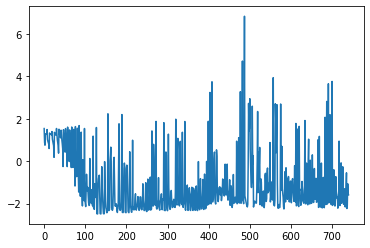

295


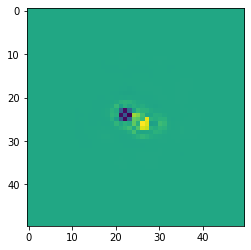

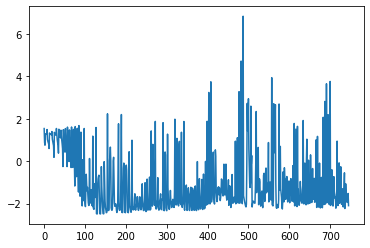

300


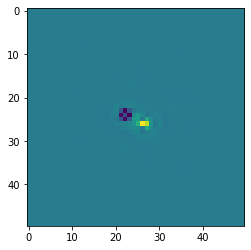

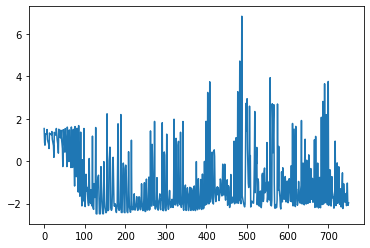

305


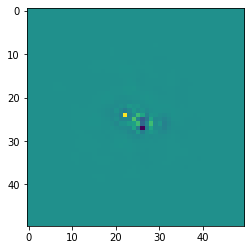

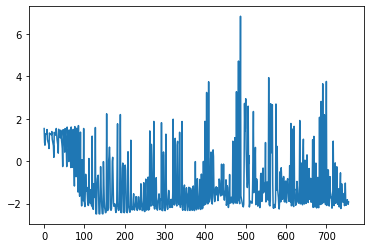

310


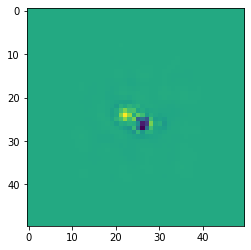

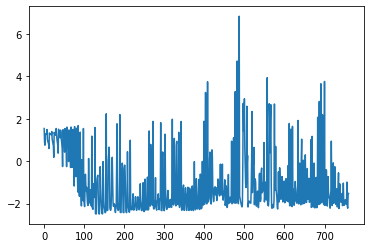

315


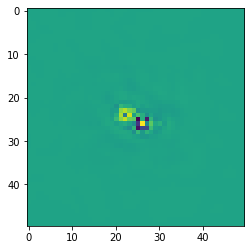

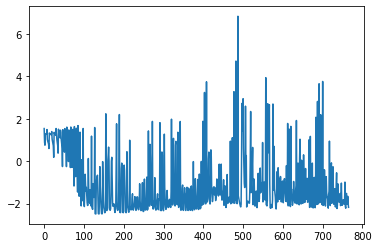

320


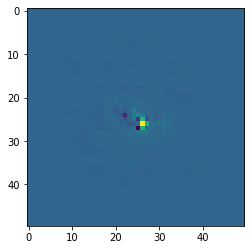

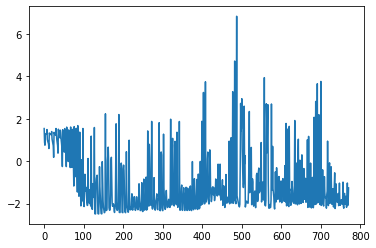

325


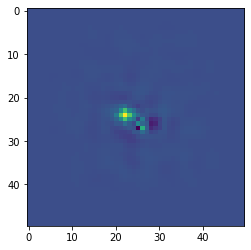

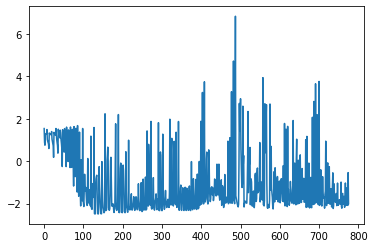

330


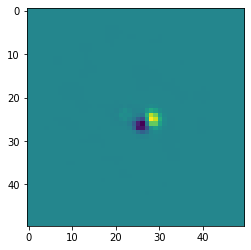

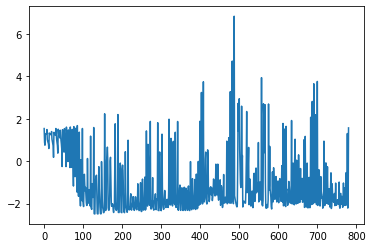

335


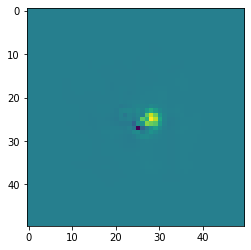

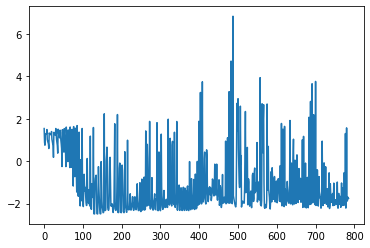

340


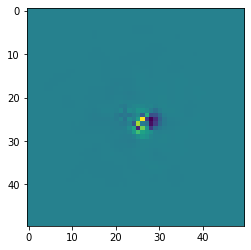

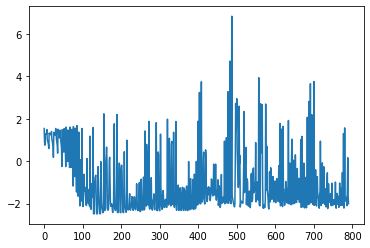

In [ ]:
for epoch in range(1500):
    
    output = model(model.x_input)
    # create mask to get rid of Nan's in target
    mask = (target == target)
    output_masked = torch.masked_select(output, mask).type_as(output)
    target_masked = torch.masked_select(target, mask).type_as(output)
    criterion=nn.MSELoss()
    loss = criterion(output_masked, target_masked)
    model.zero_grad()
    loss.backward()
    losses.append(loss.cpu().detach().numpy())
    optimizer.step()
    if epoch%5==0:
        print(epoch)
        plt.imshow(model.x_input.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
        plt.show()
        plt.plot(np.log(losses))
        plt.show()
        torch.save(model.state_dict(),os.path.join(MODEL_PATH,'input_grad_adam_2_1_1950.pt'))

## Optimizer SGD with L2 norm component

0


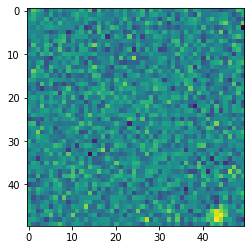

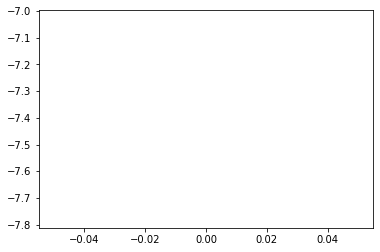

5


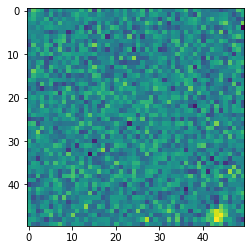

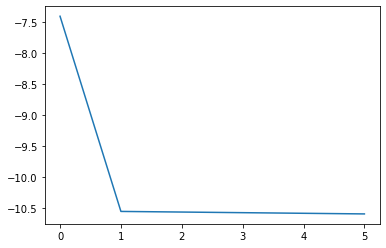

10


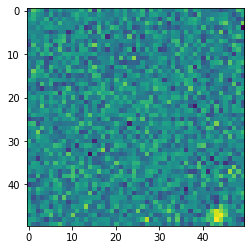

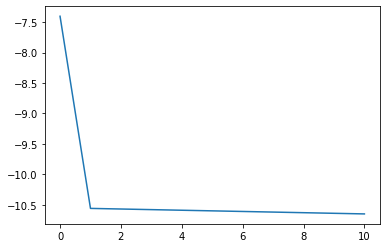

15


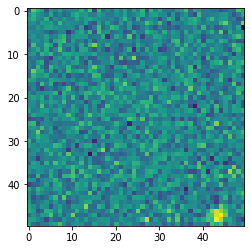

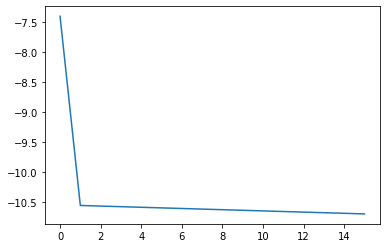

20


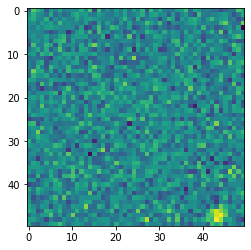

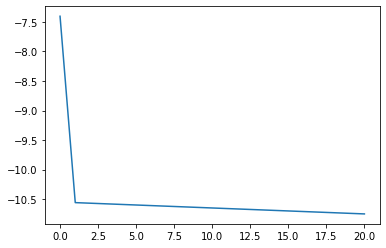

25


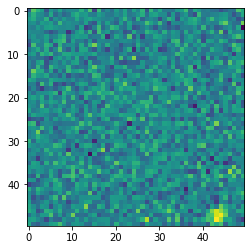

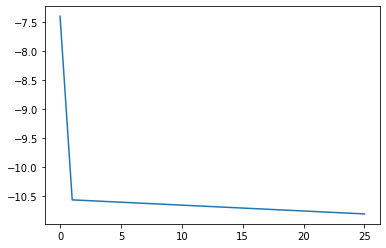

30


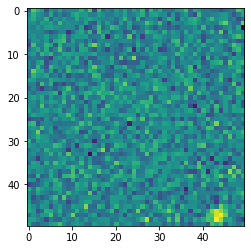

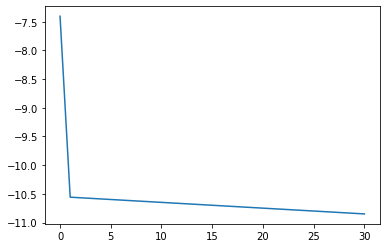

35


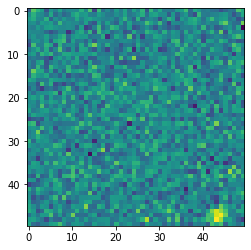

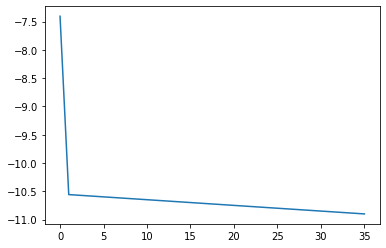

40


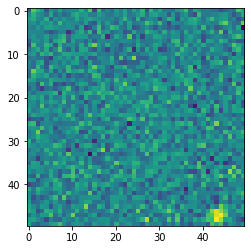

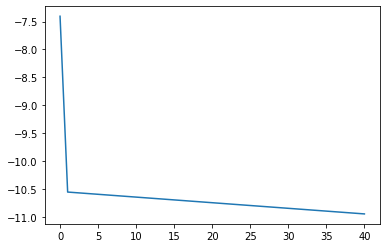

45


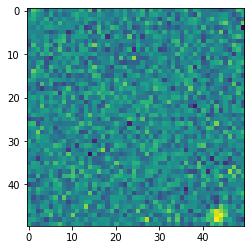

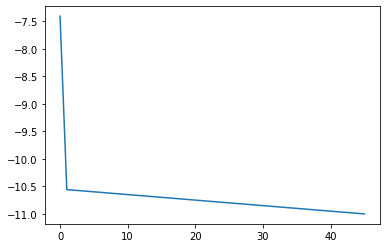

50


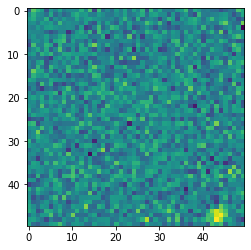

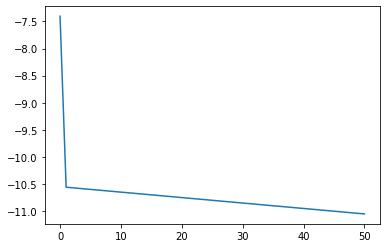

55


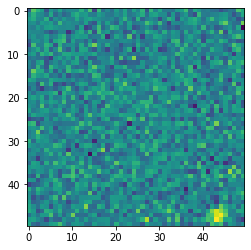

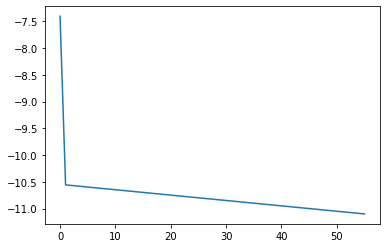

60


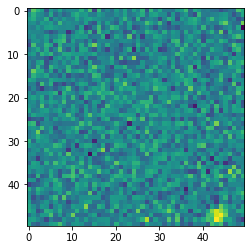

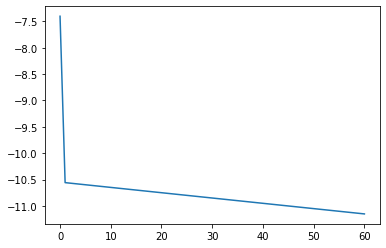

65


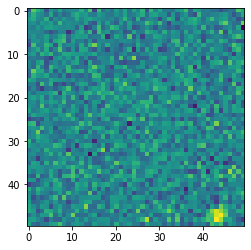

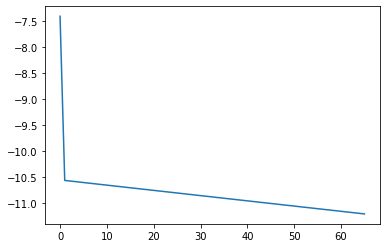

70


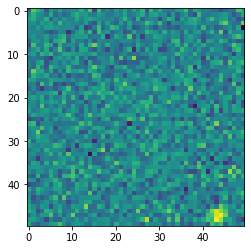

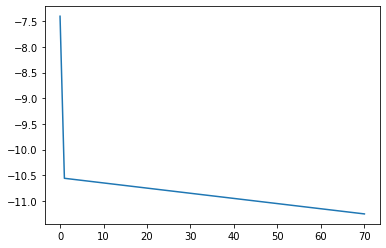

75


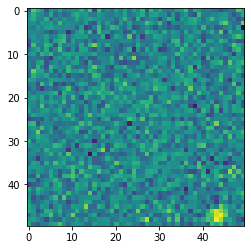

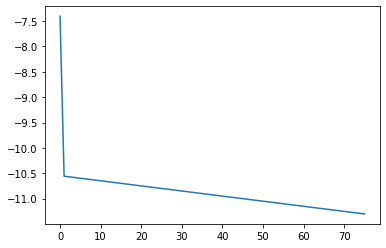

80


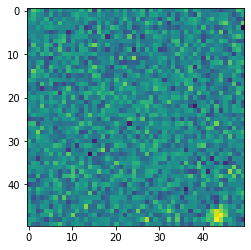

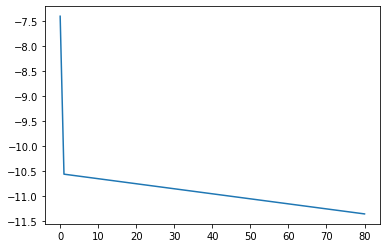

85


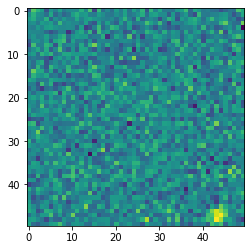

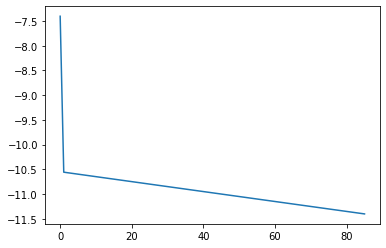

90


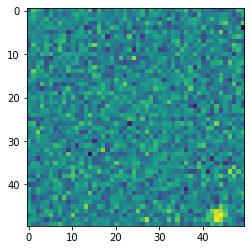

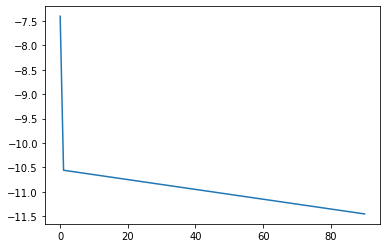

95


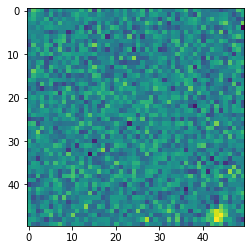

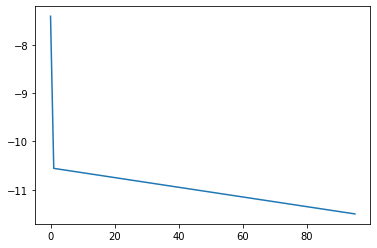

100


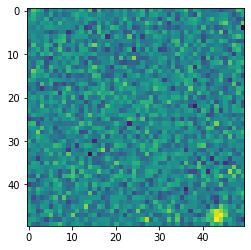

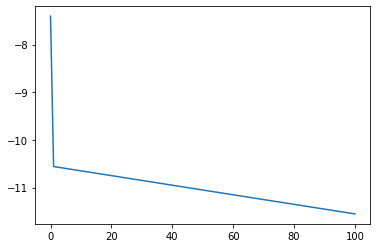

105


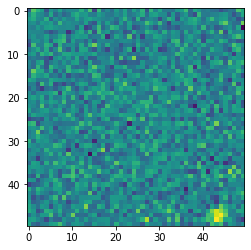

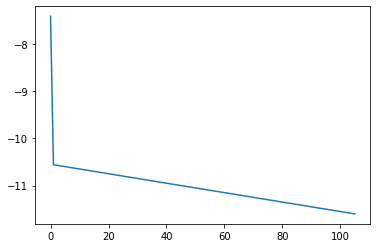

110


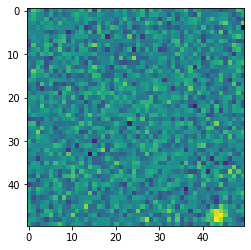

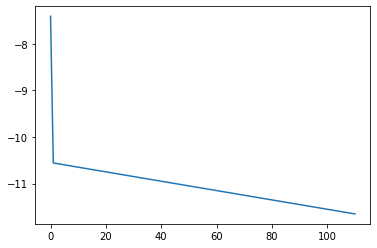

115


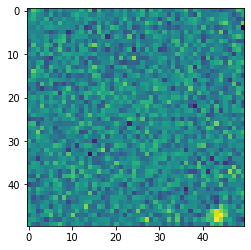

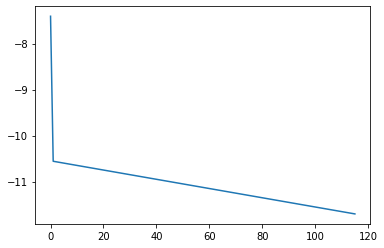

120


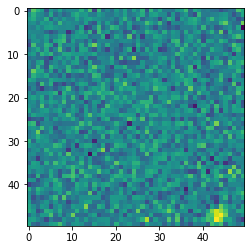

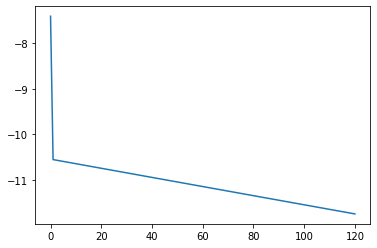

125


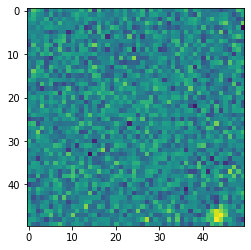

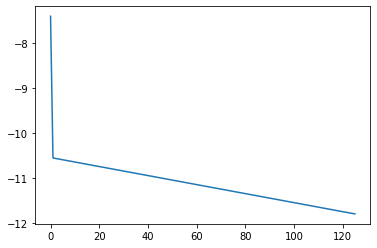

130


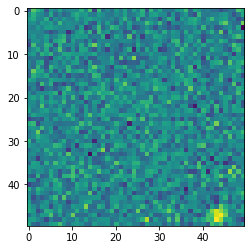

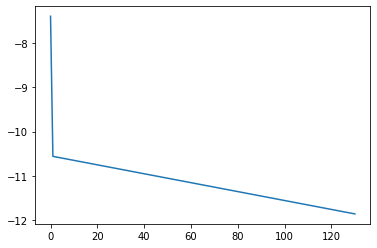

135


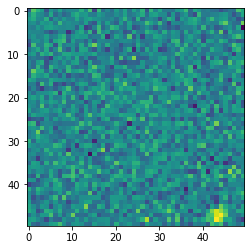

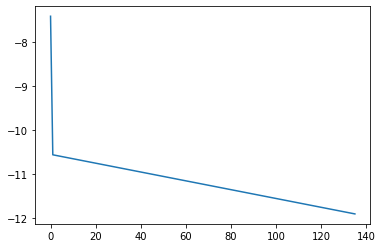

140


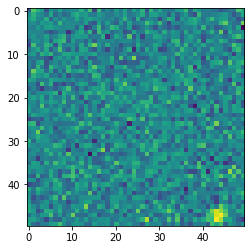

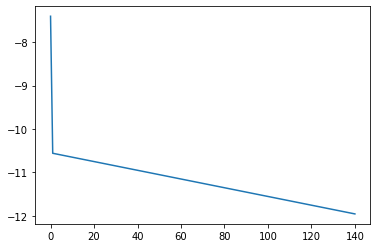

145


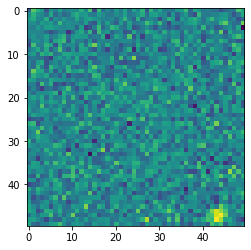

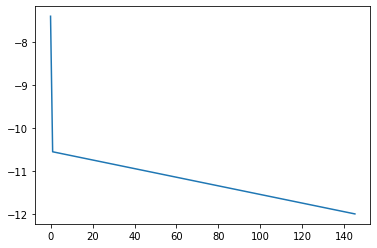

In [133]:
#https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/generate_class_specific_samples.py
from torch.autograd import Variable

molecule = Variable(torch.randn(1,9,50,50,50).to(device),requires_grad=True)
model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args['TRANSF'],device=device,sigma_0 = args['SIGMA'],sigma_trainable = args['SIGMA_TRAIN'], x_trainable=True, x_input=torch.randn(1,9,50,50,50))
model=model.to(device)
model.load_state_dict(torch.load(os.path.join(MODEL_PATH,'checkpoint.pt')))
model.x_input=Parameter(molecule,requires_grad=True)
target=torch.zeros(29)
# target[13]=1
target[15]=1

target = target.to(device)

optimizer = torch.optim.SGD([model.x_input], lr=1e2)
# optimizer = torch.optim.Adam([model.x_input], lr=1e3, weight_decay=1e-1)
losses=[]

for epoch in range(150):
    
    output = model(model.x_input)
    # create mask to get rid of Nan's in target
    mask = (target == target)
    output_masked = torch.masked_select(output, mask).type_as(output)
    target_masked = torch.masked_select(target, mask).type_as(output)
    criterion=nn.MSELoss()
    loss = criterion(output_masked, target_masked)-1e-2*torch.norm(model.x_input)
    model.zero_grad()
    loss.backward()
    losses.append(loss.cpu().detach().numpy())
    optimizer.step()
    if epoch%5==0:
        print(epoch)
        plt.imshow(model.x_input.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
        plt.show()
        plt.plot(losses)
        plt.show()